In [104]:

from experiment_information import *
from data import *
from helpers import *
from _version import __version__
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import logging
import pprint
%load_ext autoreload
%autoreload 2

import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['legend.fontsize'] = 13
mpl.rcParams['axes.titlesize'] = 15
mpl.rcParams['axes.labelsize'] = 13
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [105]:

from _version import __version__
df_experiments = None
df_state_evolution = None
df_erm = None
logger = logging.getLogger()
with DatabaseHandler(logger,"experiments/experiments.db") as dbHandler:
    df_experiments = dbHandler.get_experiments()
    df_state_evolution = dbHandler.get_state_evolutions()
    df_state_evolution["calibrations"] = df_state_evolution["calibrations"].apply(lambda x: json.loads(x))
    df_erm = dbHandler.get_erms()
    df_erm["analytical_calibrations"] = df_erm["analytical_calibrations"].apply(lambda x: json.loads(x))
    df_erm["erm_calibrations"] = df_erm["erm_calibrations"].apply(lambda x: json.loads(x))
    # delete incomplete experiments (bad, deletes running experiments...)
    # dbHandler.delete_incomplete_experiments()

# def explode_calibrations(df):
#     a = df["calibrations"].apply(pd.Series)
#     # drop the original calibrations column
#     df = df.drop(columns=["calibrations"])
#     # concat the original dataframe with the new dataframe containing the exploded calibrations column
#     df = pd.concat([df,a],axis=1)
#     # explode both calibrations and ps columns
#     df = df.explode(["calibrations","ps"])
#     # rename the exploded columns
#     df = df.rename(columns={"calibrations":"calibration","ps":"p_calibration"})
#     return df
# df_state_evolution = explode_calibrations(df_state_evolution)
# def explode_erm_calibrations(df):
#     a = df["erm_calibrations"].apply(pd.Series)
#     # drop the original calibrations column
#     df = df.drop(columns=["erm_calibrations"])
#     b = df["analytical_calibrations"].apply(pd.Series)
#     # drop the original calibrations column
#     df = df.drop(columns=["analytical_calibrations"])
#     # drop the dp and ps columns from b
#     b = b.drop(columns=["dp","ps"])
#     # rename the columns of b
#     b = b.rename(columns={"calibrations":"analytical_calibration"})
#     # rename the columns of a
#     a = a.rename(columns={"calibrations":"erm_calibration"})
#     # concat the original dataframe with the new dataframe containing the exploded calibrations column
#     df = pd.concat([df,a],axis=1)
#     df = pd.concat([df,b],axis=1)
#     # explode both calibrations and ps columns
#     df = df.explode(["erm_calibration","analytical_calibration","ps"])
#     # rename the exploded columns
#     df = df.rename(columns={"ps":"p_calibration"})
#     return df
# df_erm = explode_erm_calibrations(df_erm)

def explode_measures(df, new_columns, columns):
    for column in columns:
        def transform(column):
            # replace NaN in the column string by 0
            column = column.replace("NaN","0")
            return eval(column)
        df[column] = df[column].apply(transform)

    exploded = df.explode(columns).reset_index(drop=True)

    for new_column, column in zip(new_columns, columns):
        exploded[["attack_epsilon",new_column]] = pd.DataFrame(exploded[column].tolist(), index=exploded.index)

    exploded = exploded.drop(columns=columns)
    return exploded

def explode_erm_measures(df):
    columns = ["adversarial_generalization_errors","adversarial_generalization_errors_teacher","adversarial_generalization_errors_overlap","fair_adversarial_errors","test_losses"]
    new_columns = ["adversarial_generalization_error","adversarial_generalization_error_teacher","adversarial_generalization_error_overlap","fair_adversarial_error","test_loss"]
    return explode_measures(df, new_columns, columns)

def explode_state_evolution_measures(df):
    columns = ["adversarial_generalization_errors","adversarial_generalization_errors_teacher","fair_adversarial_errors","test_losses"]
    new_columns = ["adversarial_generalization_error","adversarial_generalization_error_teacher","fair_adversarial_error","test_loss"]
    return explode_measures(df, new_columns, columns)
    
df_erm = explode_erm_measures(df_erm)
df_state_evolution = explode_state_evolution_measures(df_state_evolution)
    

print("Current code version, ", __version__)

Current code version,  84


In [106]:
# get the completed experiments with the current code version ordered by date
version_choice = __version__
# version_choice = "68"
df_experiments = df_experiments[(df_experiments["completed"]==True) & (df_experiments["code_version"]==version_choice)]
df_experiments = df_experiments.sort_values(by="date",ascending=False)
# make the display of the second column wider
pd.set_option('display.max_colwidth', 150)
# diplay all columns
pd.set_option('display.max_columns', None)
df_experiments.head(5)

experiment_id  \
123  f8586fe8-ec27-4f75-a22e-2bc363cffb70   
120  ce121610-a4f1-4309-b5c7-1ee16267d42e   
122  9ced3415-1742-4194-bdd3-e07a630b7fd4   
121  3b749a30-6f54-4489-893a-1b937299b094   
118  b1b94ddc-8bfa-4845-b39a-2c2c0af74be3   

                                                                                                                                           experiment_name  \
123                         Sweep Alpha - KFeaturesModel - VanillaGaussianTimes10 - A Data-Model with Identity Gaussians times 10 for all the covariances.   
120                                         Sweep Alpha - KFeaturesModel - VanillaGaussian - A Data-Model with Identity Gaussians for all the covariances.   
122                     Sweep Alpha - KFeaturesModel - VanillaGaussianTimes1000 - A Data-Model with Identity Gaussians times 1000 for all the covariances.   
121                       Sweep Alpha - KFeaturesModel - VanillaGaussianTimes100 - A Data-Model with Identity Gaussians times 100 for all the covariances.   
118  Sweep High Alpha - KFeaturesModel - KFeaturesModel_TwoFeatures_ProtectingFirstHalf_AttackingIdentity_[0.5 0.5]_[10  1]_[1 1]_SD_1_10_SU_1_10 - 2 F...   

        duration problem_types code_version                 date  \
123   573.759900  ["Logistic"]           84  2023-11-24 09:59:11   
120   701.163232  ["Logistic"]           84  2023-11-24 09:40:06   
122   652.014811  ["Logistic"]           84  2023-11-24 09:39:33   
121   656.175785  ["Logistic"]           84  2023-11-24 09:39:21   
118  8824.787630  ["Logistic"]           84  2023-11-24 01:18:20   

     state_evolution_repetitions  erm_repetitions  \
123                            1               15   
120                            1               15   
122                            1               15   
121                            1               15   
118                            1               15   

                                                                                                                                               alphas  \
123  [0.1259, 0.1865, 0.2762, 0.409, 0.6058, 0.8973, 1.329, 1.9684, 2.9155, 4.3181, 6.3956, 9.4726, 14.03, 20.7801, 30.7776, 45.5852, 67.5168, 100.0]   
120  [0.1259, 0.1865, 0.2762, 0.409, 0.6058, 0.8973, 1.329, 1.9684, 2.9155, 4.3181, 6.3956, 9.4726, 14.03, 20.7801, 30.7776, 45.5852, 67.5168, 100.0]   
122  [0.1259, 0.1865, 0.2762, 0.409, 0.6058, 0.8973, 1.329, 1.9684, 2.9155, 4.3181, 6.3956, 9.4726, 14.03, 20.7801, 30.7776, 45.5852, 67.5168, 100.0]   
121  [0.1259, 0.1865, 0.2762, 0.409, 0.6058, 0.8973, 1.329, 1.9684, 2.9155, 4.3181, 6.3956, 9.4726, 14.03, 20.7801, 30.7776, 45.5852, 67.5168, 100.0]   
118                                                                                                                         [100.0, 316.2278, 1000.0]   

                                                                               epsilons  \
123                                                                [0.0, 0.2, 0.4, 0.6]   
120                                                                [0.0, 0.2, 0.4, 0.6]   
122                                                                [0.0, 0.2, 0.4, 0.6]   
121                                                                [0.0, 0.2, 0.4, 0.6]   
118  [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7]   

    test_against_epsilons  lambdas taus    ps    dp     d experiment_type  \
123       [0.0, 0.2, 0.6]  [0.001]  [0]  null  0.01   100           Sweep   
120       [0.0, 0.2, 0.6]  [0.001]  [0]  null  0.01   100           Sweep   
122       [0.0, 0.2, 0.6]  [0.001]  [0]  null  0.01   100           Sweep   
121       [0.0, 0.2, 0.6]  [0.001]  [0]  null  0.01   100           Sweep   
118  [0.0, 0.2, 0.4, 0.6]  [0.001]  [0]  null  0.01  1000           Sweep   

     completed  data_model_type  \
123          1   KFeaturesModel   
120          1  VanillaGaussian   
122          1   KFeaturesModel   
121        

In [107]:
# Version 84, Vanilla Gaussian and variances 10,100,1000
experiment_ids = ["c310f926-b8a8-4ef2-a036-f1063e64b589","0ff6e0fd-1ab4-4b9d-a223-e5c12be0f46f","41a72e46-d00f-4f2a-8562-0a0961dafdb9","0cf1dc39-d486-4081-92ea-1a76ca804bd7"]

# Version 84, Vanilla Gaussian and variances 10,100,1000 at reduced dimension d = 100
experiment_ids = ["9ced3415-1742-4194-bdd3-e07a630b7fd4","3b749a30-6f54-4489-893a-1b937299b094","f8586fe8-ec27-4f75-a22e-2bc363cffb70","ce121610-a4f1-4309-b5c7-1ee16267d42e"]

In [108]:
df_state_evolution["estimation_error"] = 1 + df_state_evolution["q"] - 2 * df_state_evolution["m"]

In [109]:
# get all experiment_loc by id
def get_experiment_loc_by_id(experiment_id):
    return df_experiments.index[df_experiments["experiment_id"]==experiment_id].tolist()[0]

experiment_locs = [get_experiment_loc_by_id(experiment_id) for experiment_id in experiment_ids]
experiment_locs

[122, 121, 123, 120]

In [110]:
for experiment_loc, id in zip(experiment_locs, experiment_ids):
    print(experiment_loc)

    # extract and print the top experiment_id
    experiment_id = df_experiments.loc[experiment_loc]["experiment_id"]
    print(experiment_id)
    assert experiment_id == id

    # extract and print the experiment type
    experiment_type = df_experiments.loc[experiment_loc]["experiment_type"]
    print(experiment_type)

    # extract and print the data model type and data_model name used
    data_model_type = df_experiments.loc[experiment_loc]["data_model_type"]
    # convert it to the enum
    data_model_type = DataModelType[data_model_type]
    data_model_name = df_experiments.loc[experiment_loc]["data_model_name"]
    data_model_description = df_experiments.loc[experiment_loc]["data_model_description"]
    print(data_model_type.name, data_model_name)
    print(data_model_description)

    # print the experiment name
    experiment_name = df_experiments.loc[experiment_loc]["experiment_name"]
    print(experiment_name)

    # print the experiment problem types
    experiment_problem_types = df_experiments.loc[experiment_loc]["problem_types"]
    experiment_problem_types = json.loads(experiment_problem_types)
    print(experiment_problem_types)

122
9ced3415-1742-4194-bdd3-e07a630b7fd4
Sweep
KFeaturesModel VanillaGaussianTimes1000
A Data-Model with Identity Gaussians times 1000 for all the covariances.
Sweep Alpha - KFeaturesModel - VanillaGaussianTimes1000 - A Data-Model with Identity Gaussians times 1000 for all the covariances.
['Logistic']
121
3b749a30-6f54-4489-893a-1b937299b094
Sweep
KFeaturesModel VanillaGaussianTimes100
A Data-Model with Identity Gaussians times 100 for all the covariances.
Sweep Alpha - KFeaturesModel - VanillaGaussianTimes100 - A Data-Model with Identity Gaussians times 100 for all the covariances.
['Logistic']
123
f8586fe8-ec27-4f75-a22e-2bc363cffb70
Sweep
KFeaturesModel VanillaGaussianTimes10
A Data-Model with Identity Gaussians times 10 for all the covariances.
Sweep Alpha - KFeaturesModel - VanillaGaussianTimes10 - A Data-Model with Identity Gaussians times 10 for all the covariances.
['Logistic']
120
ce121610-a4f1-4309-b5c7-1ee16267d42e
Sweep
VanillaGaussian VanillaGaussian
A Data-Model with Ide

In [111]:
experiment_descriptors = [1000,100,10,1]

In [112]:
def get_experiment_descriptor_by_id(experiment_id):
    # get the experiment_loc by id by looking up the experiment_ids
    experiment_loc = experiment_ids.index(experiment_id) 
    return experiment_descriptors[experiment_loc]


In [113]:
round_to = 2
def my_floor(a, precision=round_to):
    return np.round(a - 0.5 * 10**(-precision), precision)
state_evolution = df_state_evolution[df_state_evolution["experiment_id" ].isin(experiment_ids)]
# apply get_experiment_descriptor_by_id to the experiment_id column
state_evolution["variance"] = state_evolution["experiment_id"].apply(get_experiment_descriptor_by_id)

# ceil the alpha values to 1 decimal
state_evolution["alpha"] = state_evolution["alpha"].apply(lambda x: my_floor(x,precision=round_to))
erm = df_erm[df_erm["experiment_id" ].isin(experiment_ids)]
# apply get_experiment_descriptor_by_id to the experiment_id column
erm["variance"] = erm["experiment_id"].apply(get_experiment_descriptor_by_id)

gd = erm[erm["chosen_minimizer"] == "sklearn"]
# ceil the alpha values to 1 decimal
gd["alpha"] = gd["alpha"].apply(lambda x: my_floor(x,precision=round_to))


# set alpha, epsilon, tau, lam as index in gd and state_evolution
gd = gd.set_index(["alpha","epsilon","tau","lam","problem_type","attack_epsilon","variance"]) #,"p_calibration"
state_evolution = state_evolution.set_index(["alpha","epsilon","tau","lam","problem_type","attack_epsilon","variance"]) #,"p_calibration"
# from state_evolution keep generalization_error, sigma, q, m, angle
state_evolution = state_evolution[["generalization_error","sigma","q","Q_self","m","angle","training_loss","estimation_error","sigma_hat","q_hat","m_hat","adversarial_generalization_error","training_error","A","N","A_hat","N_hat","test_loss","adversarial_generalization_error_teacher","fair_adversarial_error","F","P"]] #calibration
# add a suffix _state_evolution to the columns
state_evolution.columns = [col+"_state_evolution" for col in state_evolution.columns]
# from gd keep generalization_error_erm	generalization_error_overlap Q	rho	m	angle
gd = gd[["generalization_error_erm","generalization_error_overlap","Q","rho","m","angle", "training_error","d", "training_loss","test_loss","adversarial_generalization_error","adversarial_generalization_error_overlap","A","N", "adversarial_generalization_error_teacher","fair_adversarial_error","P","F"]] #,"erm_calibration","analytical_calibration"
# add a suffix _erm to the columns
gd.columns = [col+"_erm" for col in gd.columns]
# join the two dataframes (if a value is missing in one of the two dataframes, it is filled with NaN)
df = state_evolution.join(gd, how="outer")
# reorder the columns
df = df[['generalization_error_state_evolution', 'generalization_error_erm_erm', 'generalization_error_overlap_erm', 'sigma_state_evolution', 'q_state_evolution','Q_erm',"Q_self_state_evolution",'m_state_evolution','m_erm','angle_state_evolution','angle_erm', 'rho_erm',"training_loss_state_evolution","training_loss_erm","training_error_erm","d_erm","test_loss_erm","estimation_error_state_evolution","sigma_hat_state_evolution","q_hat_state_evolution","m_hat_state_evolution","adversarial_generalization_error_state_evolution","adversarial_generalization_error_overlap_erm","adversarial_generalization_error_erm","training_error_state_evolution","A_erm","N_erm","A_state_evolution","N_state_evolution","A_hat_state_evolution","N_hat_state_evolution","test_loss_state_evolution", "adversarial_generalization_error_teacher_erm","adversarial_generalization_error_teacher_state_evolution","fair_adversarial_error_state_evolution","fair_adversarial_error_erm","P_state_evolution","P_erm","F_state_evolution","F_erm"]] #,"erm_calibration_erm","analytical_calibration_erm","calibration_state_evolution"
# average all quantities over the index and obtain also the standard deviation
df = df.groupby(level=[0,1,2,3,4,5,6]).agg(["mean","std"]) #,4
# display all columns
# pd.set_option('display.max_columns', None)
# # display all rows
# pd.set_option('display.max_rows', None)
df.sort_index()
df

/tmp/ipykernel_3572912/775904622.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  state_evolution["variance"] = state_evolution["experiment_id"].apply(get_experiment_descriptor_by_id)
/tmp/ipykernel_3572912/775904622.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  state_evolution["alpha"] = state_evolution["alpha"].apply(lambda x: my_floor(x,precision=round_to))
/tmp/ipykernel_3572912/775904622.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

generalization_error_state_evolution  \
                                                                                              mean   
alpha  epsilon tau lam   problem_type attack_epsilon variance                                        
0.12   0.0     0.0 0.001 Logistic     0.0            1                                    0.410276   
                                                     10                                   0.394445   
                                                     100                                  0.394445   
                                                     1000                                 0.394445   
                                      0.2            1                                    0.410276   
...                                                                                            ...   
100.00 0.6     0.0 0.001 Logistic     0.2            1000                                 0.072479   
                                      0.6            1                                    0.028447   
                                                     10                                   0.072479   
                                                     100                                  0.072479   
                                                     1000                                 0.072479   

                                                                    \
                                                               std   
alpha  epsilon tau lam   problem_type attack_epsilon variance        
0.12   0.0     0.0 0.001 Logistic     0.0            1         0.0   
                                                     10        0.0   
                                                     100       0.0   
                                                     1000      0.0   
                                      0.2            1         0.0   
...                                                            ...   
100.00 0.6     0.0 0.001 Logistic     0.2            1000      0.0   
                                      0.6            1         0.0   
                                                     10        0.0   
                                                     100       0.0   
                                                     1000      0.0   

                                                              generalization_error_erm_erm  \
                                                                                      mean   
alpha  epsilon tau lam   problem_type attack_epsilon variance                                
0.12   0.0     0.0 0.001 Logistic     0.0            1                            0.412229   
                                                     10                           0.394693   
                                                     100                          0.405147   
                                                     1000                         0.401320   
                                      0.2            1                            0.412229   
...                                                                                    ...   
100.00 0.6     0.0 0.001 Logistic     0.2            1000                         0.071653   
                                      0.6            1                            0.027335   
                                                     10                           0.070833   
                                                     100                          0.072580   
                                                     1000                         0.071653   

                                                                         \
                                                                    std   
alpha  epsilon tau lam   problem_type attack_epsilon variance             
0.12   0.0     0.0 0.001 Logistic     0.0            1         0.013130   
                                   

In [114]:
optimal_lambdas = load_csv_to_object_dictionary(OptimalLambdaResult(0,0,0,0,None,None,None),path="experiments/")
def extract_optimal_lambda(alpha, epsilon, tau, data_model_type, data_model_name, problem_type):
    # extract or compute optimal lamba and plot it as a vertical line
    optimal_result = OptimalLambdaResult(alpha,epsilon,tau,1,data_model_type,data_model_name, problem_type)
    if optimal_result.get_key() in optimal_lambdas:
        optimal_lambda = optimal_lambdas[optimal_result.get_key()]
        return optimal_lambda
    else:   
        print("Optimal lambda not found for ", optimal_result.get_key())
        return None
    

In [115]:
first_iteration = "tau"
second_iteration = "lam" #"lam" # "lam"
third_iteration = "epsilon"
target = "alpha"
sweep = "variance"

save_plots = False
description = "Alpha_Sweep_Small_Reg"

def get_path(problem_type, filename = None):
    # make sure the directory for the data_model_name exists
    directory = f"Assets/{data_model_name}"
    if not os.path.exists(directory):
        os.makedirs(directory)

    # encode the sweep type as a directory
    sweep_name = f"CE_{sweep}_x_{target}_different_{sweep}_many_{second_iteration}"
    directory = f"Assets/{data_model_name}/{sweep_name}"
    if not os.path.exists(directory):
        os.makedirs(directory)

    # encode the problem type as a directory
    directory = f"Assets/{data_model_name}/{sweep_name}/{problem_type}"
    if not os.path.exists(directory):
        os.makedirs(directory)


    if filename is None:
        filename = description
    
    directory = f"Assets/{data_model_name}/{sweep_name}/{problem_type}/{filename}/"
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    return f"Assets/{data_model_name}/{sweep_name}/{problem_type}/{filename}/"

def create_plot(df, error_name, state_evolution_name, gd_name, log_x = True, log_y=True, fix_a_variable = None, variable_value = None, filename=None, plot_attack_epsilon=False):
    df2 = df.reset_index()
    df2.sort_index()
    # Define a color palette to use for the different epsilon values
    palette = sns.color_palette(n_colors=len(df2[sweep].unique()))

    d = df2['d_erm']["mean"][0]

    attack_epsilons = df2["attack_epsilon"].unique()
    if not plot_attack_epsilon:
        # assign just the first attack_epsilon
        attack_epsilons = [attack_epsilons[0]]

    for attack_epsilon in attack_epsilons:

        for problem_type in df2["problem_type"].unique():

            for tau in df2[first_iteration].unique():

                iterate_over = df2[second_iteration].unique() if second_iteration is not None else [None]

                for lam in iterate_over:

                    third_filter = df2[third_iteration].unique() if third_iteration is not None else [None]

                    for descriptor in third_filter:

                        fig = plt.figure()
                        ax = plt.subplot(111)

                        # Filter the dataframe for the current values of tau and lam
                        if second_iteration is None:
                            data = df2[(df2[first_iteration] == tau) & (df2["problem_type"] == problem_type) & (df2["attack_epsilon"] == attack_epsilon)]
                        else:
                            data = df2[(df2[first_iteration] == tau) & (df2[second_iteration] == lam) & (df2["problem_type"] == problem_type) & (df2["attack_epsilon"] == attack_epsilon)]

                        if third_filter is not None:
                            data = data[data[third_iteration] == descriptor]

                        if fix_a_variable is not None:
                            data = data[data[fix_a_variable] == variable_value]
                        
                    
                        for i, epsilon in enumerate(data[sweep].unique()):

                            # Filter the dataframe for the current value of epsilon and descriptor
                            epsilon_subset = data[data[sweep] == epsilon]                      
                        

                            # Plot the state_evolution results as a line
                            if state_evolution_name is not None:
                                if state_evolution_name in ["alpha","tau","lam","epsilon"]:
                                    ax.plot(epsilon_subset[target], epsilon_subset[(state_evolution_name)], label=f'{sweep}: {epsilon:.4f}', color=palette[i])
                                else:
                                    ax.plot(epsilon_subset[target], epsilon_subset[(state_evolution_name, 'mean')], label=f'{sweep}: {epsilon:.4f}', color=palette[i])
                            
                            # Plot the gradient_descent results as points with error bars
                            if gd_name is not None:
                                try:
                                    ax.errorbar(epsilon_subset[target], epsilon_subset[(gd_name, 'mean')], yerr=epsilon_subset[(gd_name, 'std')], fmt='o', color=palette[i], capsize=5)
                                except:
                                    pass

                            if error_name == "Generalization Error" and target == "lam":
                                optimal_lambda = extract_optimal_lambda(alpha=lam, epsilon=epsilon, tau=tau, data_model_type=data_model_type, data_model_name=data_model_name, problem_type=ProblemType[problem_type])
                                # plot the optimal lambda as a vertical line
                                if optimal_lambda is not None:
                                    ax.axvline(x=optimal_lambda, color=palette[i], linestyle='--')

                        
                        if log_x:
                            plt.xscale('log')
                            # plt.xscale('symlog')
                        if log_y:
                            plt.yscale('log')

                        # Add labels and title
                        plt.xlabel(target)
                        plt.ylabel(error_name)
                        title = f"{error_name} - {problem_type} - {first_iteration}: {tau}, {third_iteration}: {descriptor}"
                        if fix_a_variable is not None:
                            if second_iteration is None:
                                title += f' d: {d} - {fix_a_variable}: {variable_value}'
                            else:
                                title += f' {second_iteration}: {lam}, d: {d} - {fix_a_variable}: {variable_value}'
                        else:
                            if second_iteration is None:
                                title += f' d: {d}'
                            else:
                                title += f' {second_iteration}: {lam}, d: {d}'
                        if plot_attack_epsilon:
                            title += f" - attack_epsilon: {attack_epsilon}"
                        plt.title(title,y=1.1)
                        

                        box = ax.get_position()
                        ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

                        # Put a legend to the right of the current axis
                        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

                        # add a grid
                        plt.grid()

                        plt.tight_layout()

                        if fix_a_variable is not None:
                            name = f"{error_name}_{problem_type}_{data_model_name}_{third_iteration}_{descriptor}_tau_{tau}_lam_{lam}_d_{d}_{fix_a_variable}_{variable_value}_v_{__version__}"
                        else:
                            name = f"{error_name}_{problem_type}_{data_model_name}_{third_iteration}_{descriptor}_tau_{tau}_lam_{lam}_d_{d}_v_{__version__}"
                        if plot_attack_epsilon:
                            name += f"_attack_epsilon_{attack_epsilon}"
                        # Save the plot as svg
                        if filename is not None or save_plots:


                            path = get_path(problem_type, filename)

                            plt.savefig(f"{path}{name}.pdf", bbox_inches='tight')

                        # Show the plot
                        plt.show()


In [116]:
# Write some code to store all information about the data_model in a json file next to all the plots
if save_plots:
    for problem_type in experiment_problem_types:
        path = get_path(problem_type)

        experiment_dict = {}

        for experiment_loc in experiment_locs:

            # get an ExperimentInformation object from one entry in df_experiments
            experiment = ExperimentInformation.from_df(df_experiments.loc[experiment_loc])

            # load the data_model and store it in a dictionary
            data_model = experiment.get_data_model(logger,source_pickle_path="")
            data_model_dict = data_model.__dict__
            # remove the logger from the dictionary
            del data_model_dict["logger"]
            # add the code version to the dictionary
            data_model_dict["code_version"] = __version__
            # add the experiment_id to the dictionary
            data_model_dict["experiment_id"] = experiment_id
            # add the experiment_name to the dictionary
            data_model_dict["experiment_name"] = experiment_name
            # add the experiment_problem_types to the dictionary
            data_model_dict["experiment_problem_types"] = experiment_problem_types
            # add the experiment_type to the dictionary
            data_model_dict["experiment_type"] = experiment_type

            # remove all _abc_data
            for key in list(data_model_dict.keys()):
                if "_abc" in key:
                    del data_model_dict[key]
                
            # remove all methods
            for key in list(data_model_dict.keys()):
                if callable(data_model_dict[key]):
                    del data_model_dict[key]

            # add the data_model_dict to the experiment_dict
            experiment_dict[experiment_loc] = data_model_dict
        

        # store the dictionary as a json file
        with open(f"{path}_data_models.json", 'w') as fp:
            pp = pprint.PrettyPrinter(indent=4)
            text = pp.pformat(experiment_dict)
            fp.write(text)
            

In [117]:
# create_plot(df, "Calibration", "calibration_state_evolution","erm_calibration_erm",fix_a_variable="alpha", variable_value=1.0)
# create_plot(df, "Calibration", "calibration_state_evolution","erm_calibration_erm",fix_a_variable="alpha", variable_value=2.0)
# create_plot(df, "Calibration", "calibration_state_evolution","erm_calibration_erm",fix_a_variable="alpha", variable_value=5.0)
# create_plot(df, "Calibration", "calibration_state_evolution","erm_calibration_erm",fix_a_variable="alpha", variable_value=15.0)

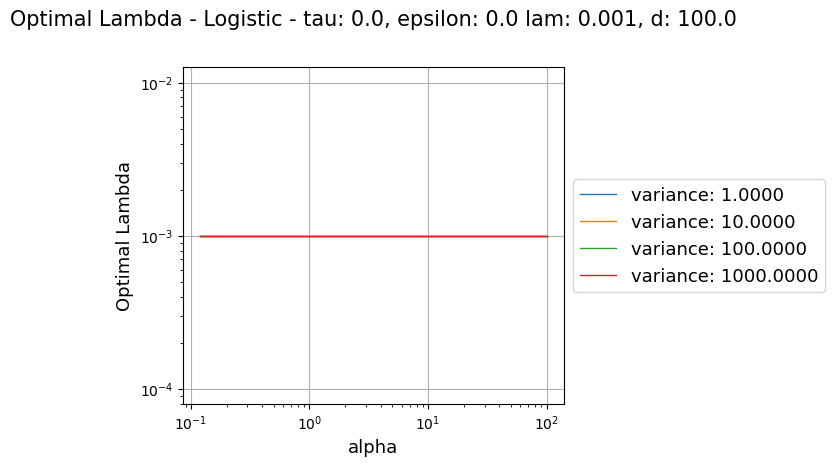

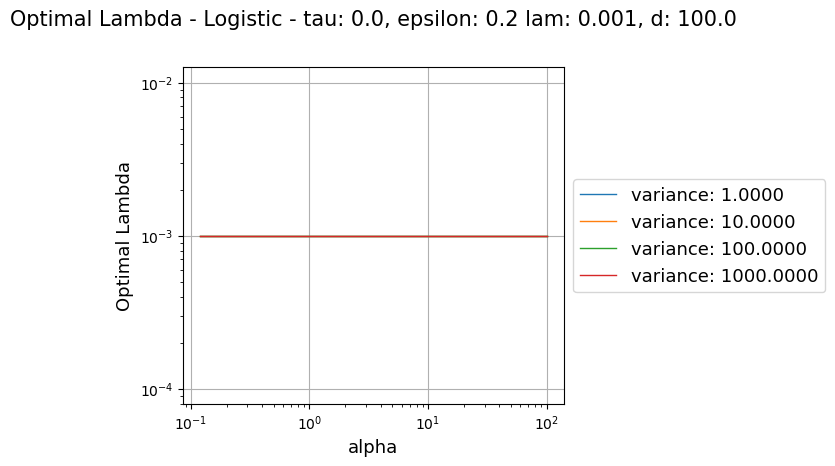

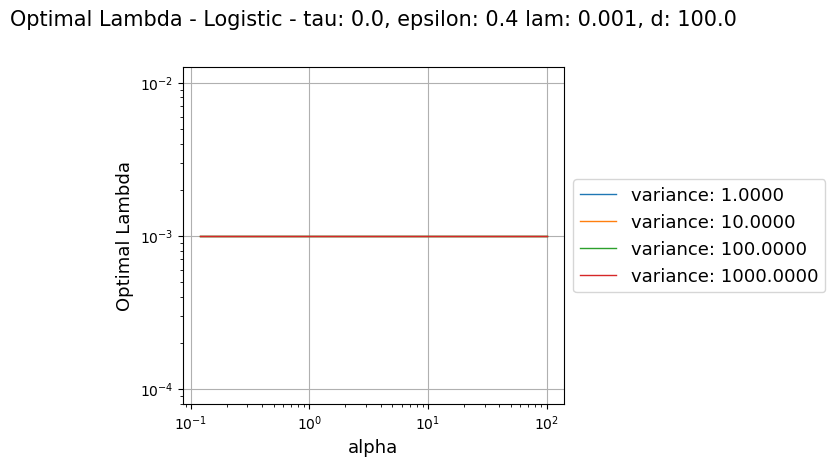

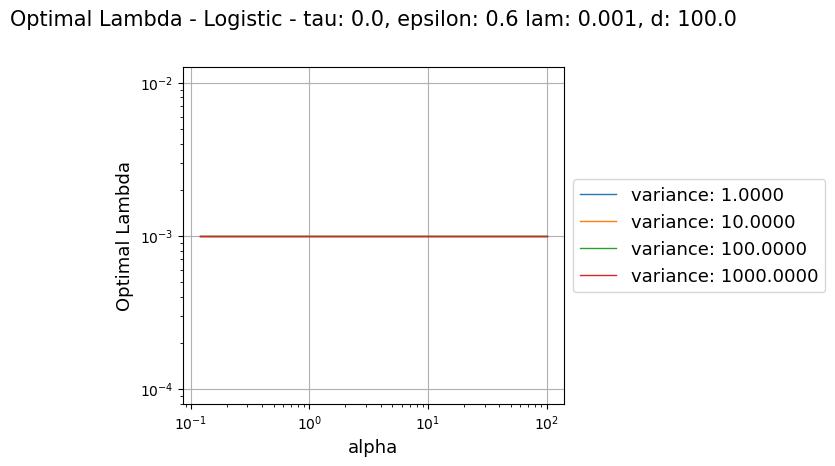

In [118]:
create_plot(df,"Optimal Lambda", "lam", None)

/ssoft/spack/syrah/v1/opt/spack/linux-rhel8-icelake/gcc-11.3.0/python-3.10.4-mcloxmxhlovfwwkxzyafm35bq545ntqx/lib/python3.10/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/ssoft/spack/syrah/v1/opt/spack/linux-rhel8-icelake/gcc-11.3.0/python-3.10.4-mcloxmxhlovfwwkxzyafm35bq545ntqx/lib/python3.10/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


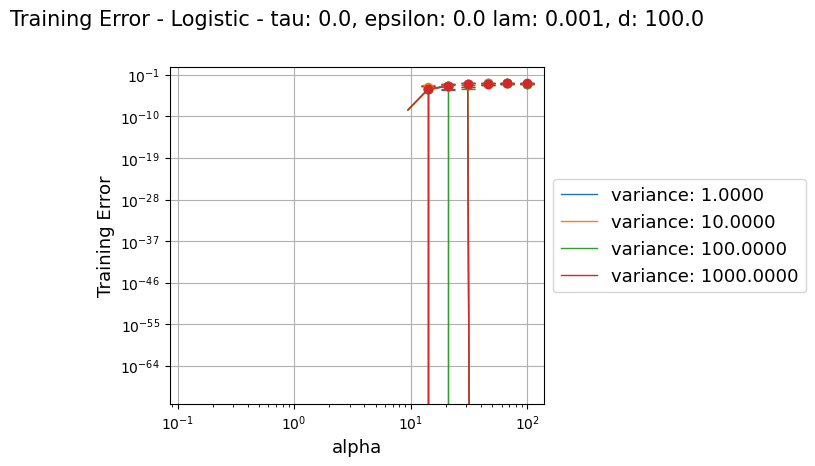

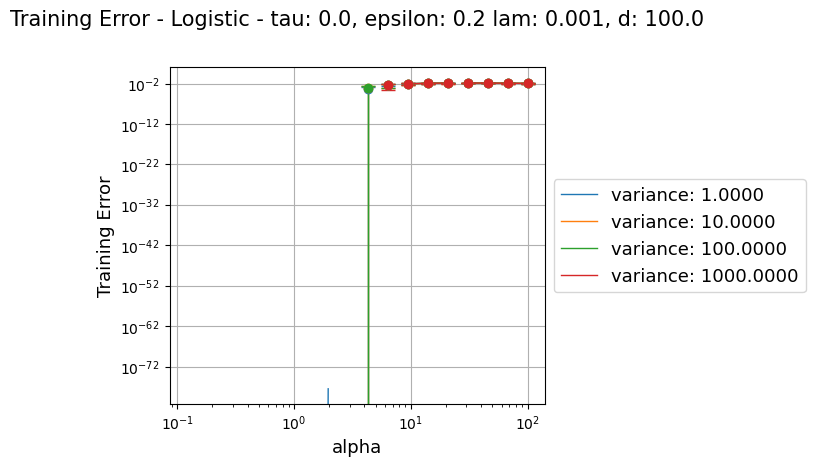

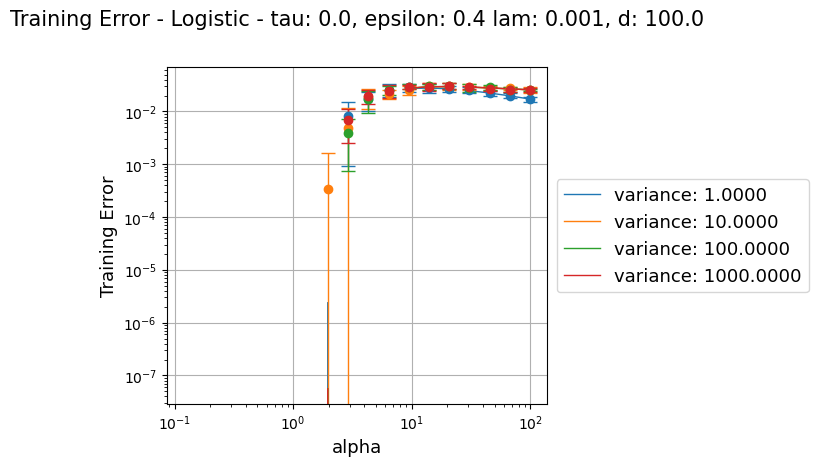

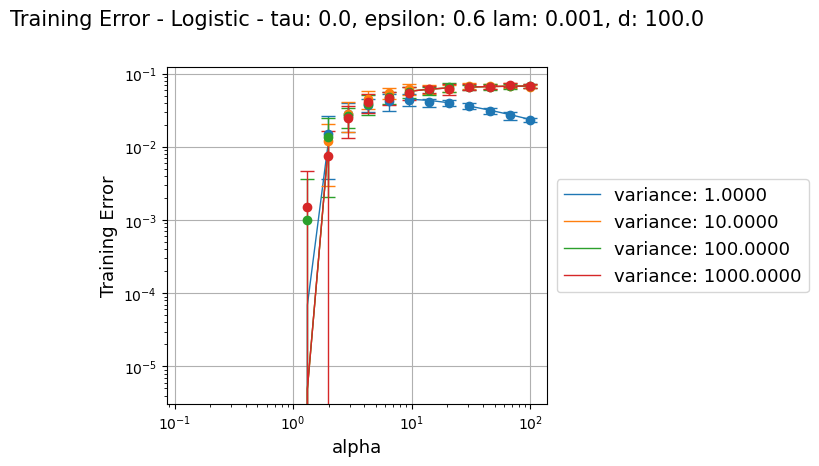

In [119]:
# plot the erm training error
create_plot(df, "Training Error", "training_error_state_evolution","training_error_erm")

In [120]:
# # Let's add a new column to the dataframe for the training error in terms of erm overlaps, except for sigma

# df.apply()

# training_error_overlaps: float = training_error_logistic(m,Q,sigma,A,N,rho,n/d,tau,epsilon, lam)

/ssoft/spack/syrah/v1/opt/spack/linux-rhel8-icelake/gcc-11.3.0/python-3.10.4-mcloxmxhlovfwwkxzyafm35bq545ntqx/lib/python3.10/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/ssoft/spack/syrah/v1/opt/spack/linux-rhel8-icelake/gcc-11.3.0/python-3.10.4-mcloxmxhlovfwwkxzyafm35bq545ntqx/lib/python3.10/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


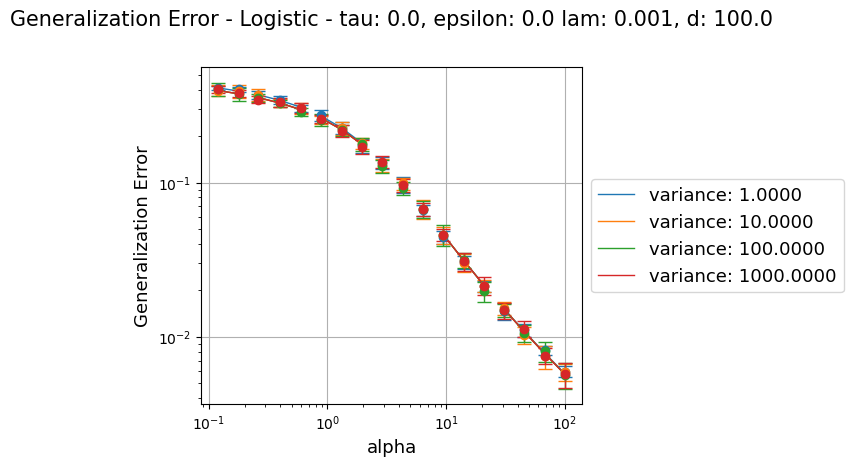

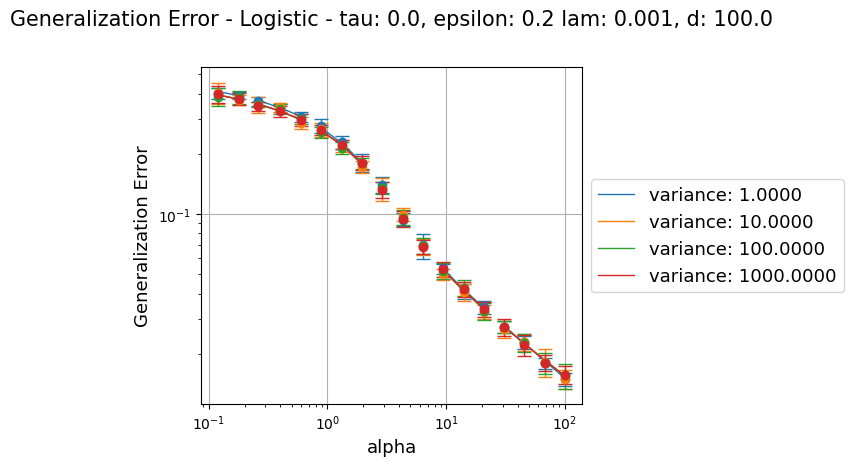

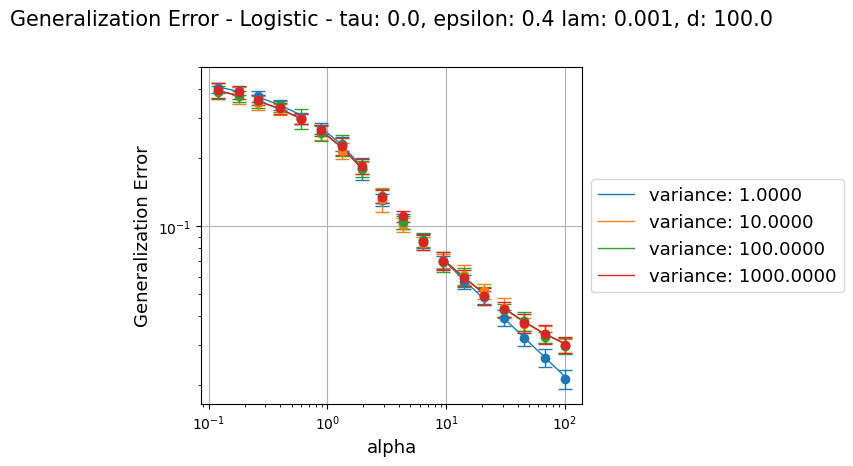

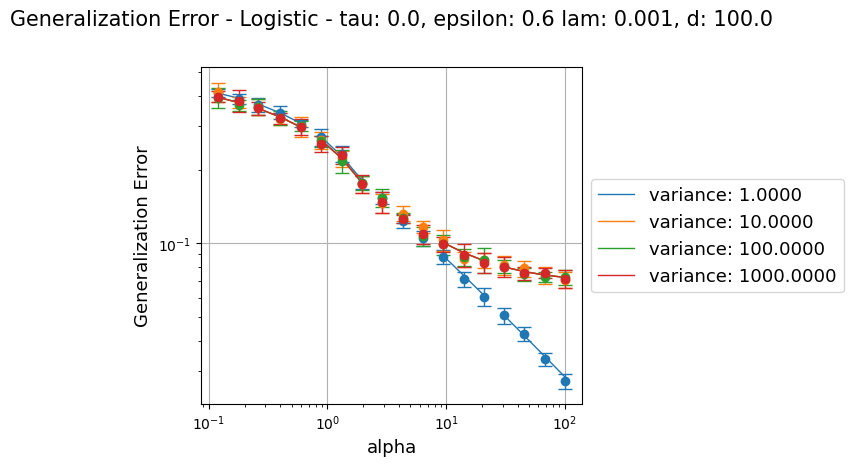

In [121]:
create_plot(df, "Generalization Error", "generalization_error_state_evolution", "generalization_error_erm_erm", log_y=True)

/ssoft/spack/syrah/v1/opt/spack/linux-rhel8-icelake/gcc-11.3.0/python-3.10.4-mcloxmxhlovfwwkxzyafm35bq545ntqx/lib/python3.10/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/ssoft/spack/syrah/v1/opt/spack/linux-rhel8-icelake/gcc-11.3.0/python-3.10.4-mcloxmxhlovfwwkxzyafm35bq545ntqx/lib/python3.10/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


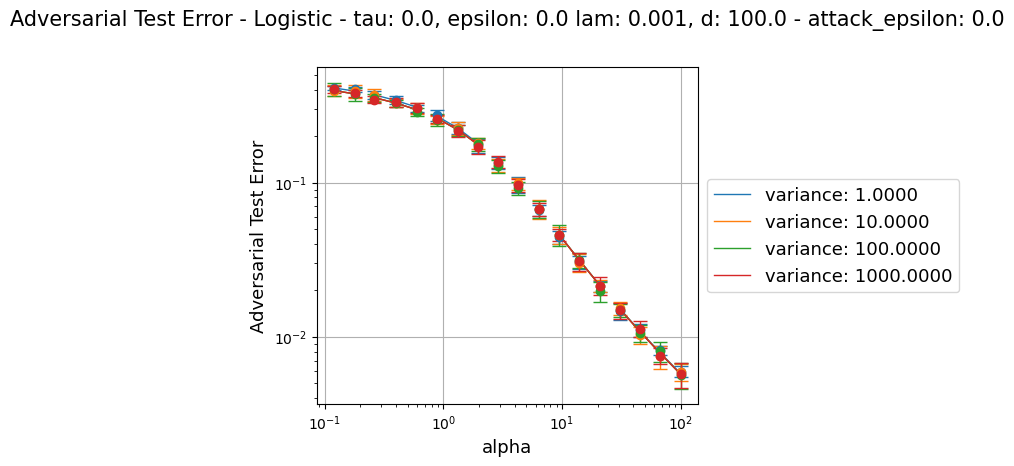

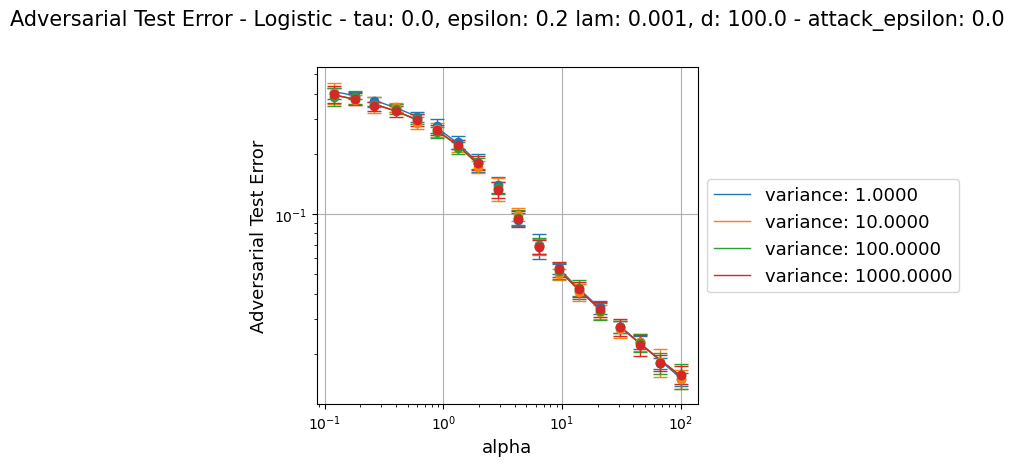

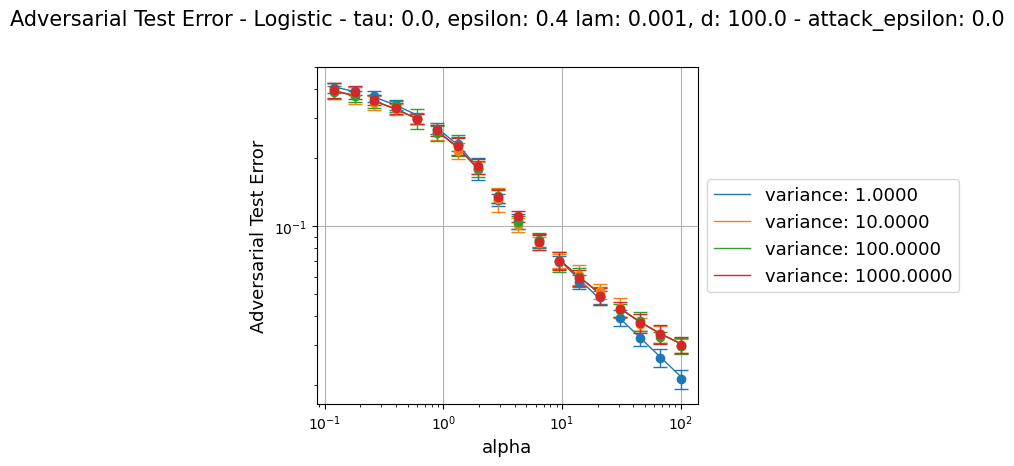

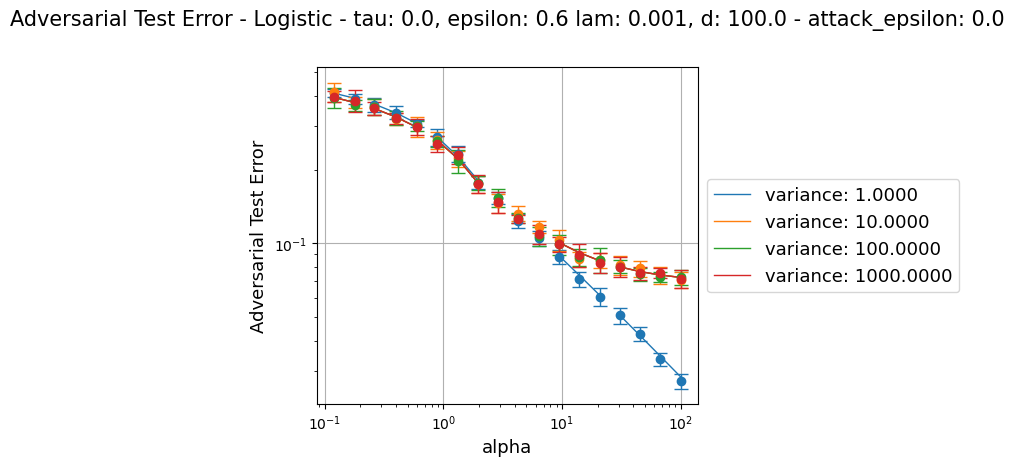

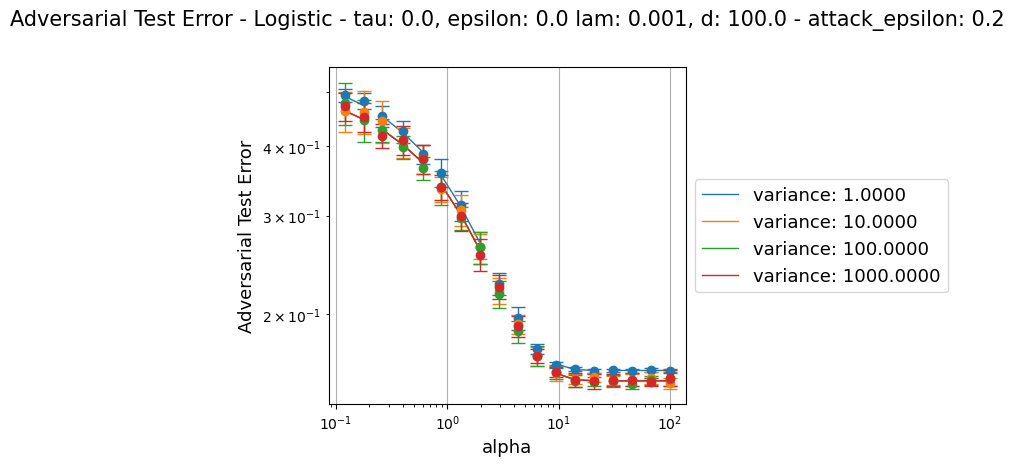

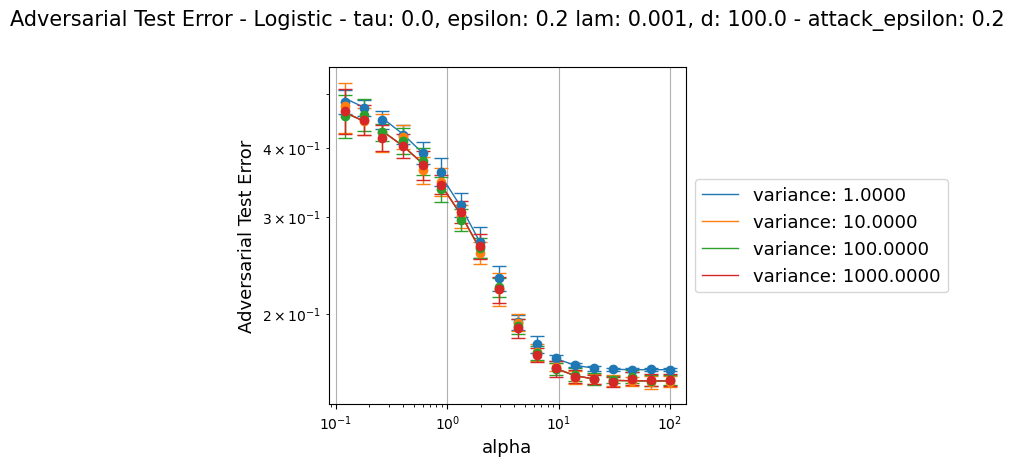

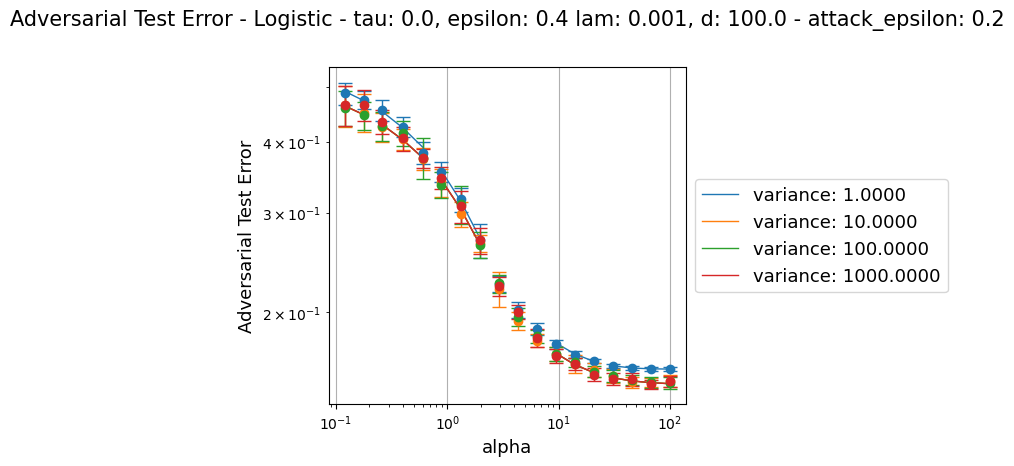

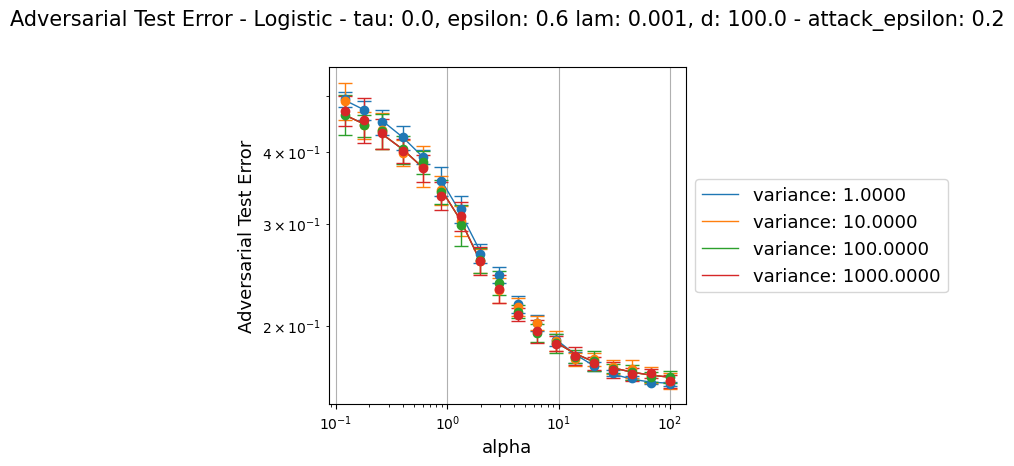

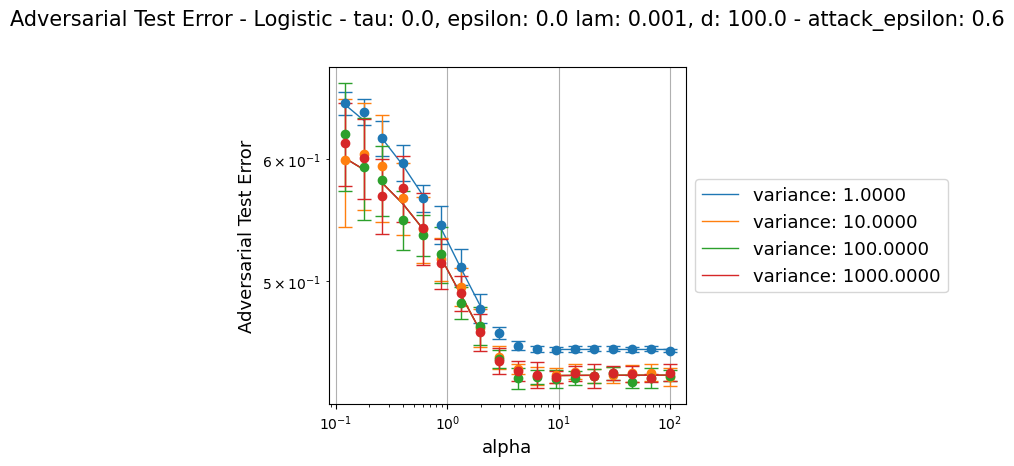

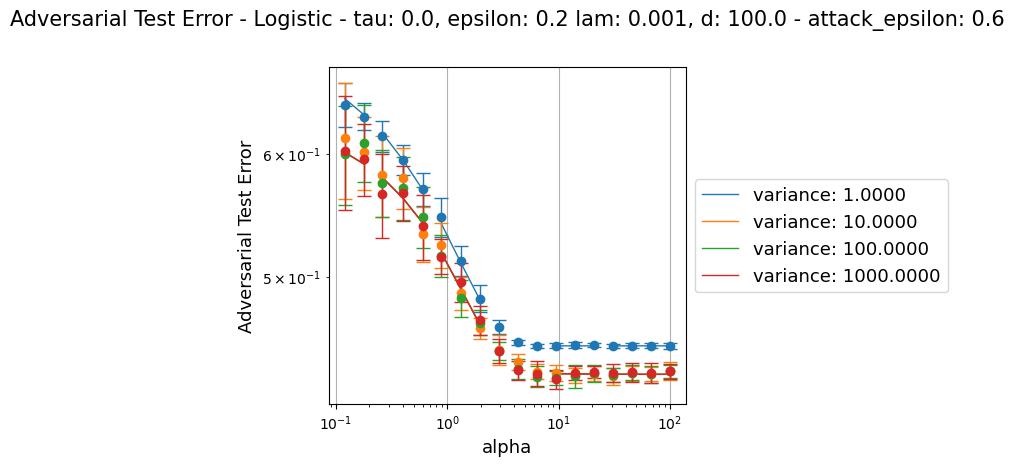

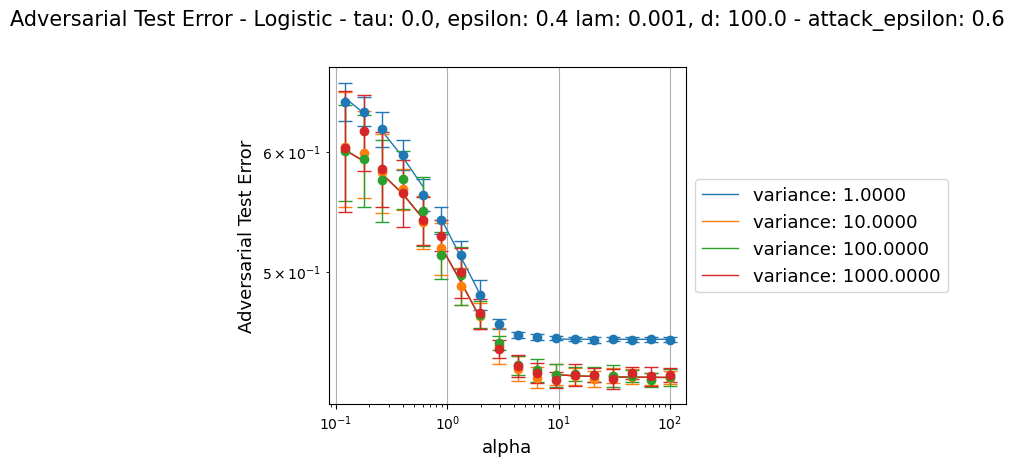

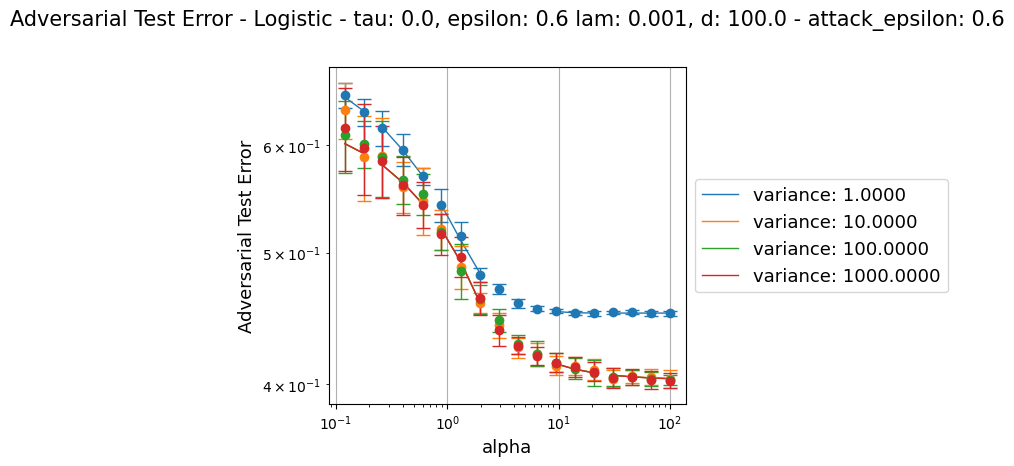

In [122]:
create_plot(df, "Adversarial Test Error", "adversarial_generalization_error_state_evolution", "adversarial_generalization_error_erm",log_y=True,log_x=True,plot_attack_epsilon=True)

/ssoft/spack/syrah/v1/opt/spack/linux-rhel8-icelake/gcc-11.3.0/python-3.10.4-mcloxmxhlovfwwkxzyafm35bq545ntqx/lib/python3.10/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/ssoft/spack/syrah/v1/opt/spack/linux-rhel8-icelake/gcc-11.3.0/python-3.10.4-mcloxmxhlovfwwkxzyafm35bq545ntqx/lib/python3.10/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
/tmp/ipykernel_3572912/701215386.py:111: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


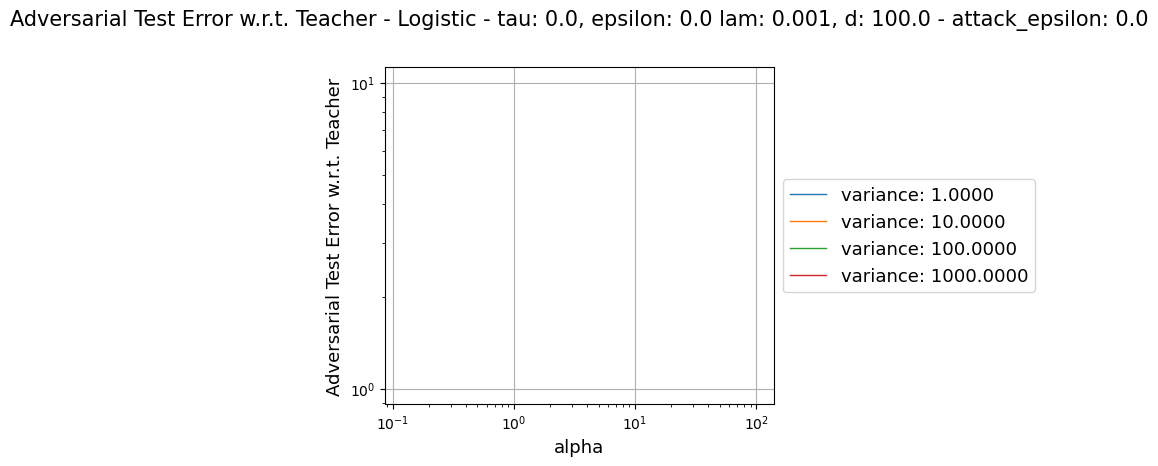

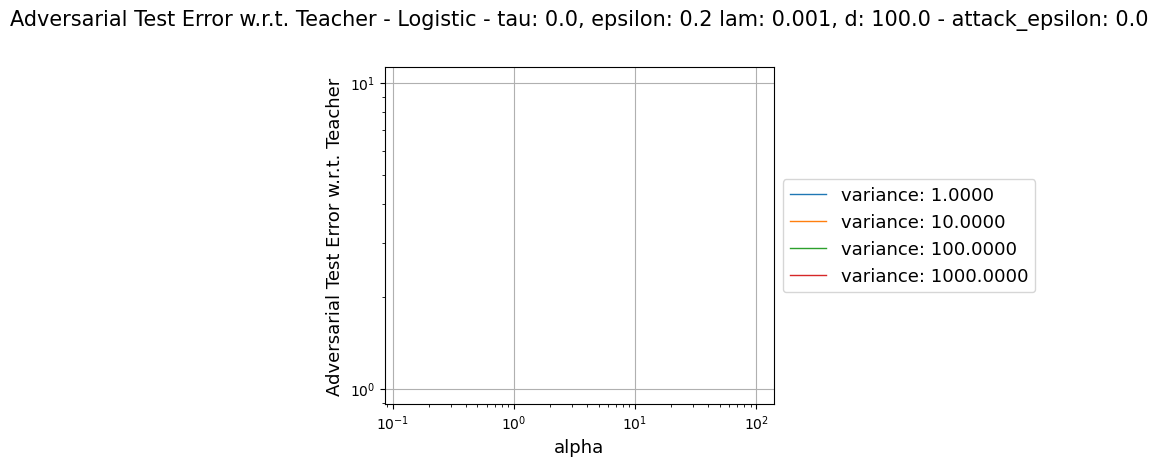

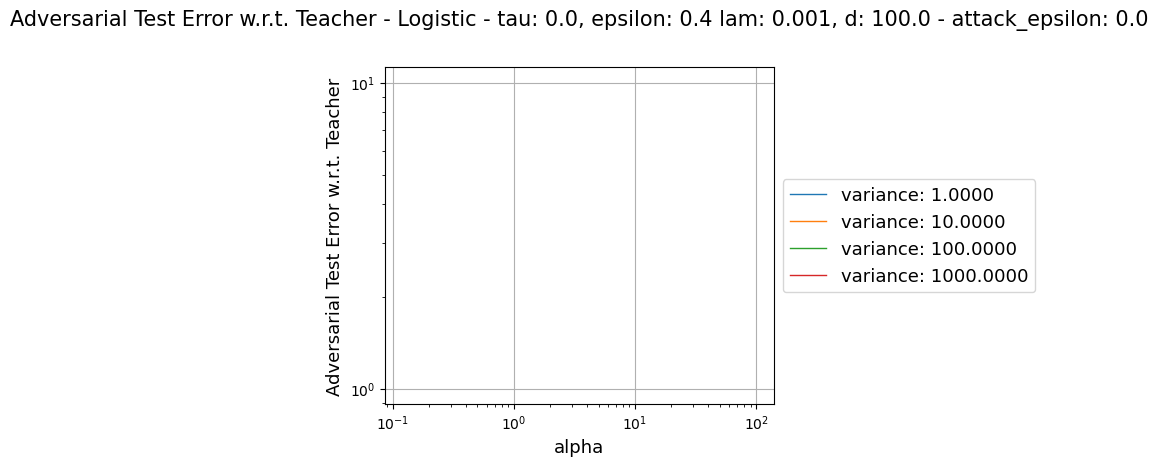

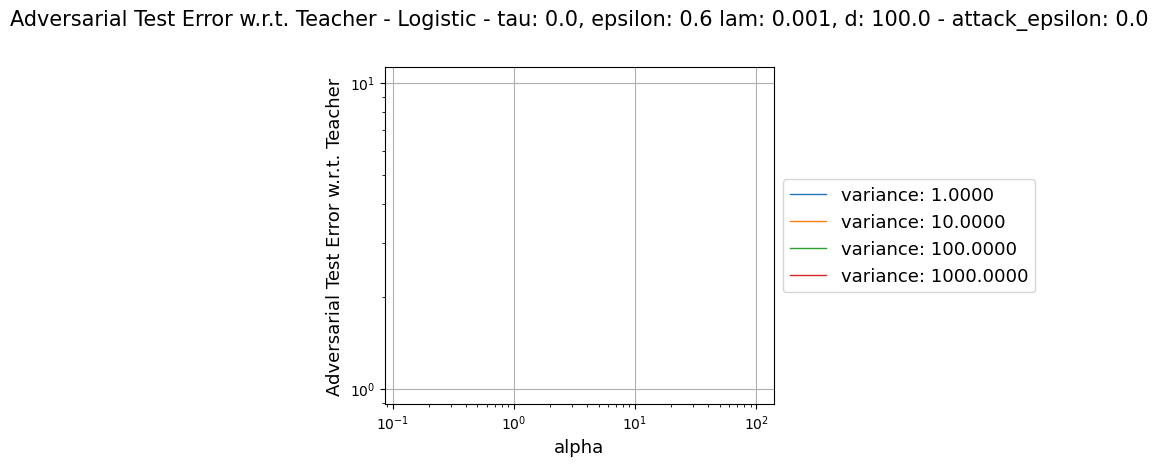

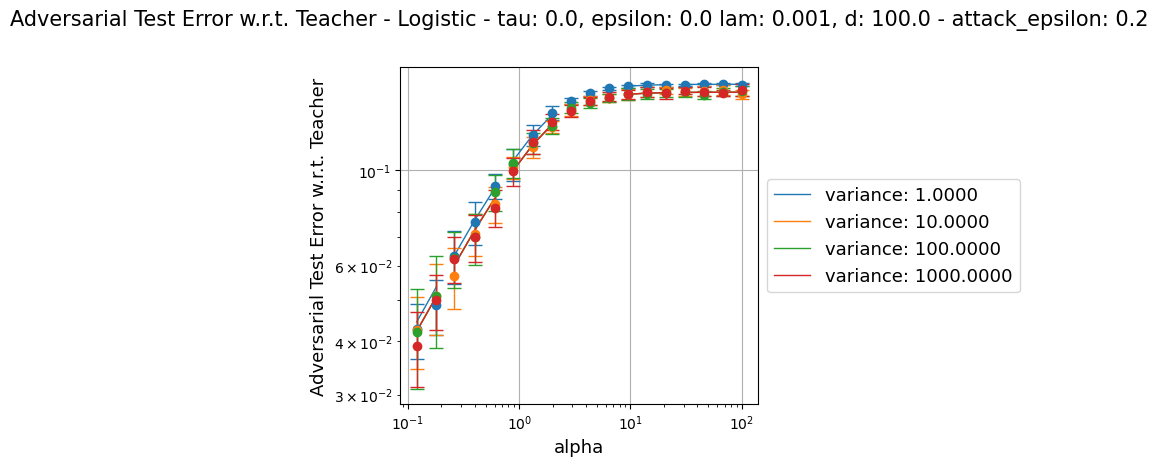

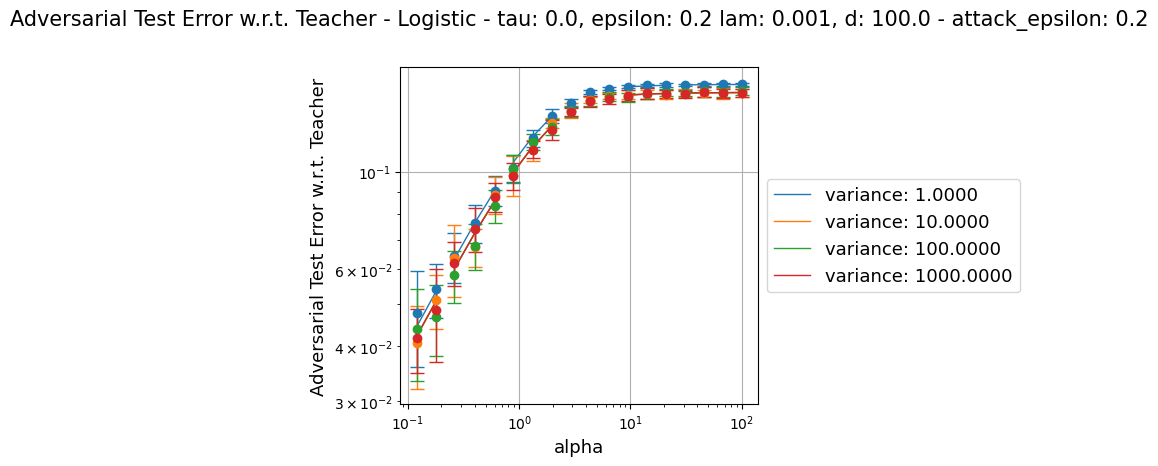

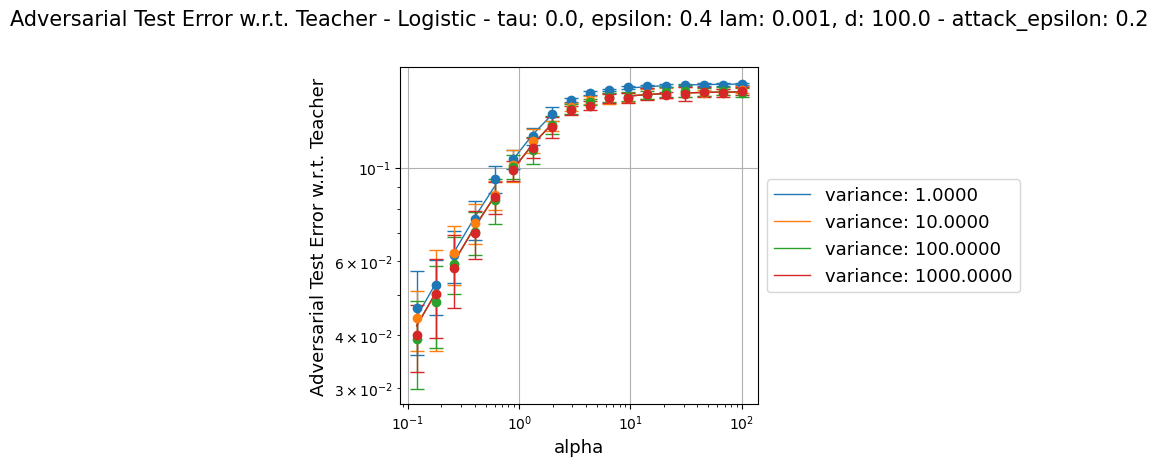

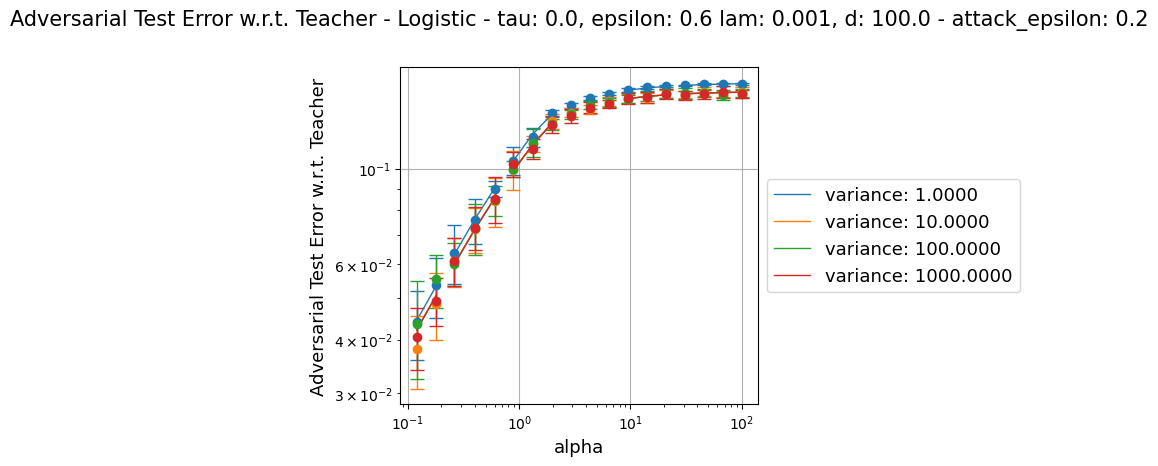

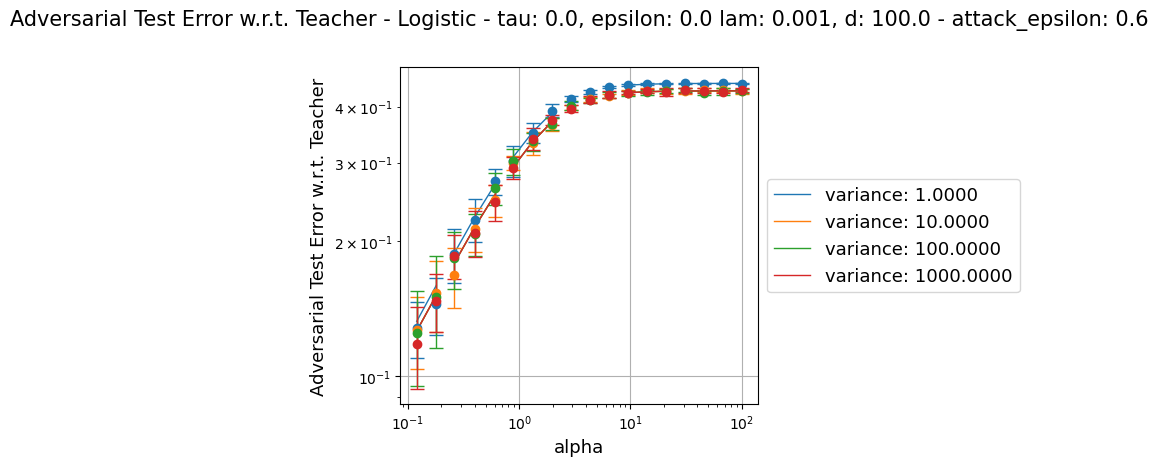

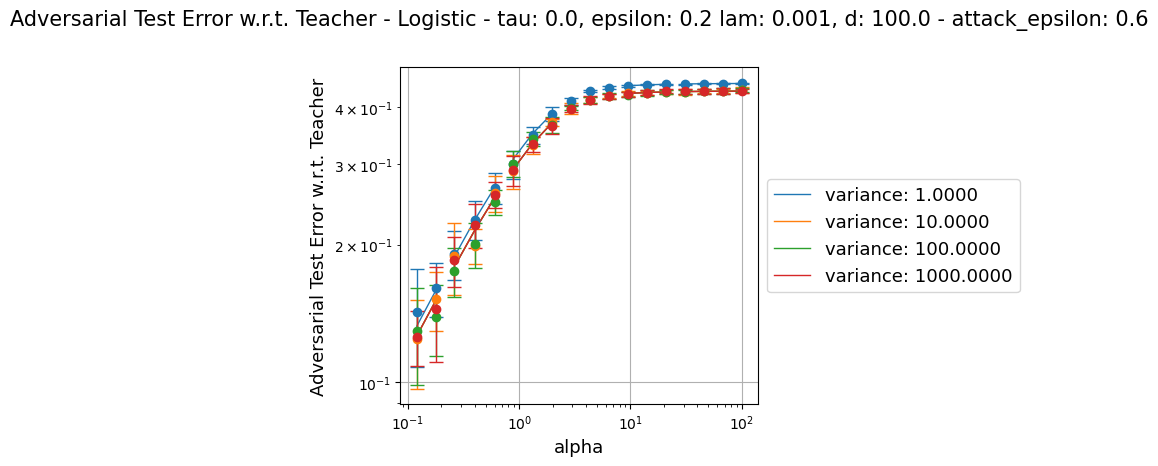

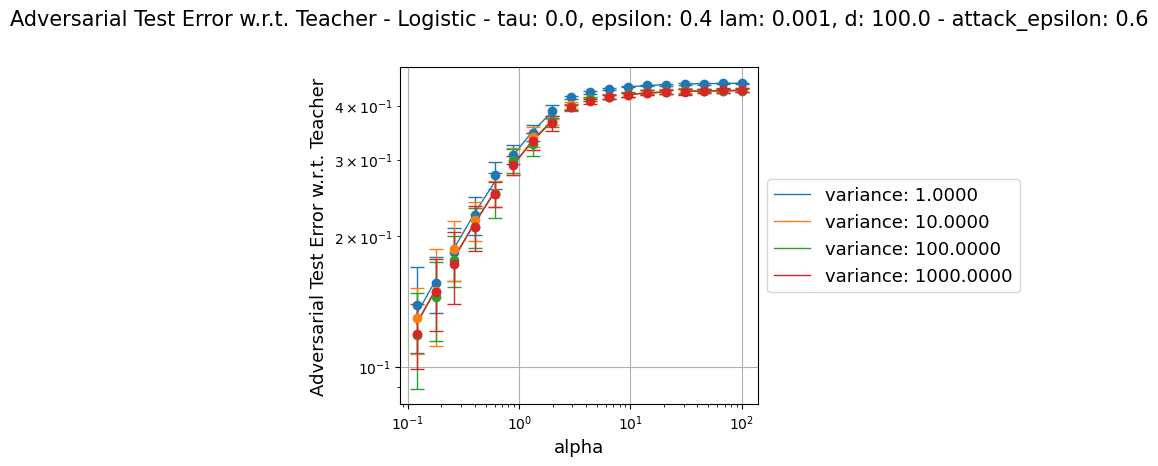

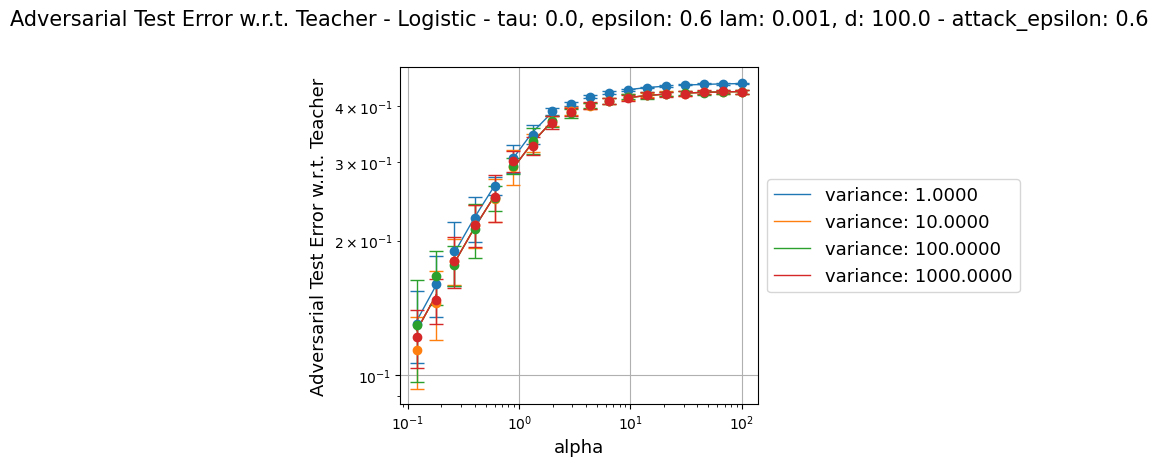

In [123]:
create_plot(df, "Adversarial Test Error w.r.t. Teacher", "adversarial_generalization_error_teacher_state_evolution", "adversarial_generalization_error_teacher_erm",log_y=True,log_x=True,plot_attack_epsilon=True)

/ssoft/spack/syrah/v1/opt/spack/linux-rhel8-icelake/gcc-11.3.0/python-3.10.4-mcloxmxhlovfwwkxzyafm35bq545ntqx/lib/python3.10/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/ssoft/spack/syrah/v1/opt/spack/linux-rhel8-icelake/gcc-11.3.0/python-3.10.4-mcloxmxhlovfwwkxzyafm35bq545ntqx/lib/python3.10/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


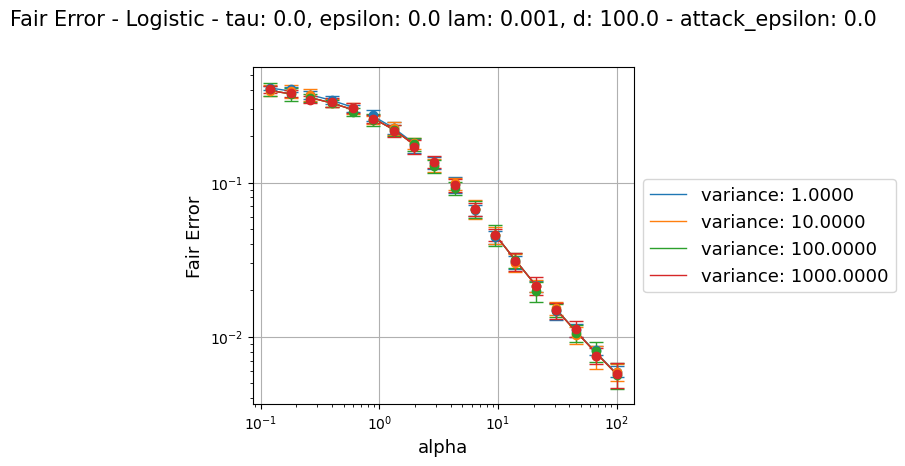

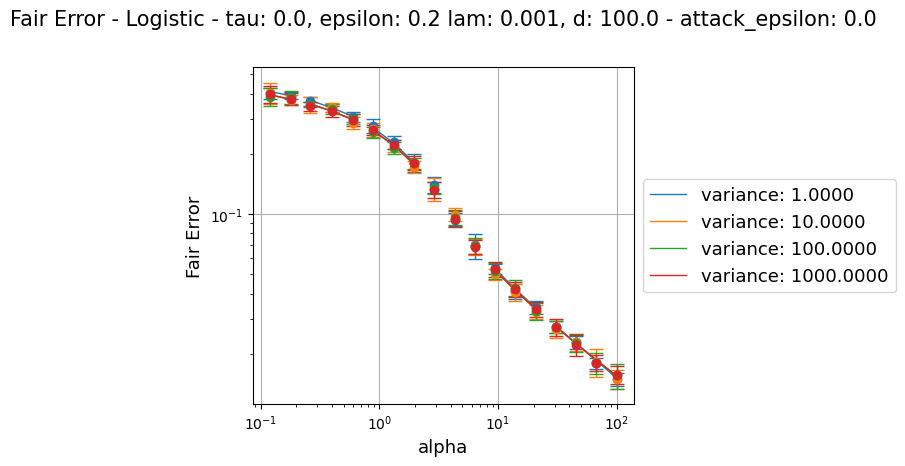

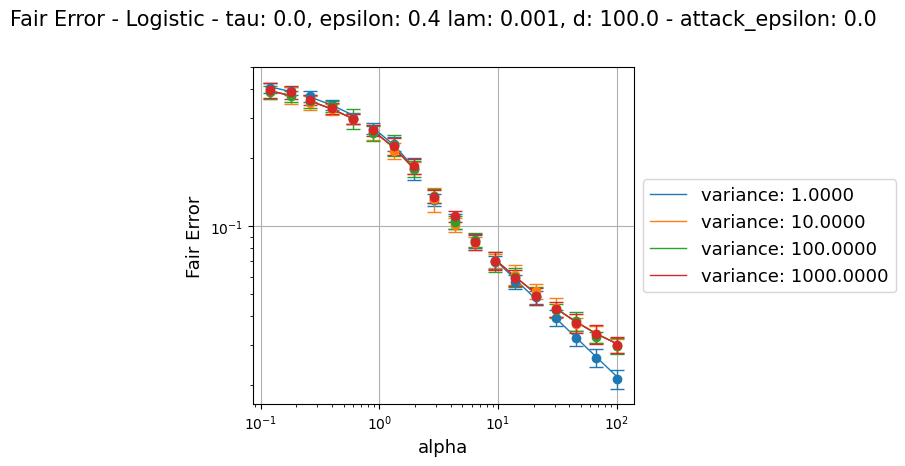

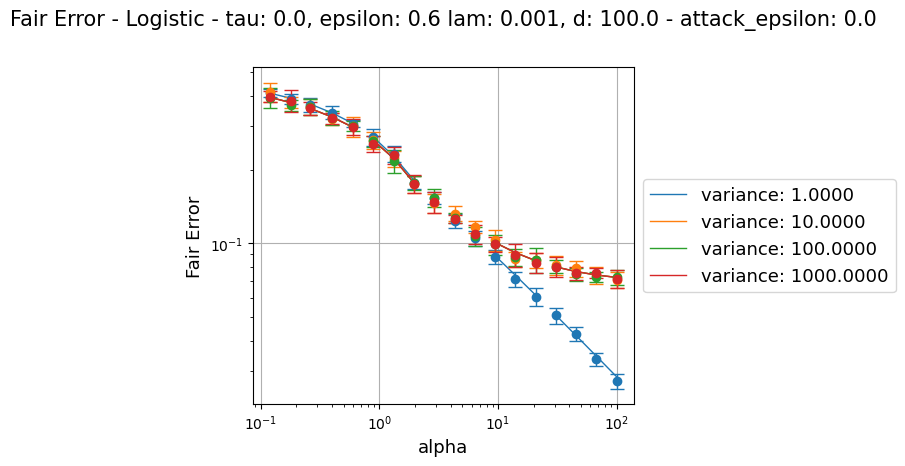

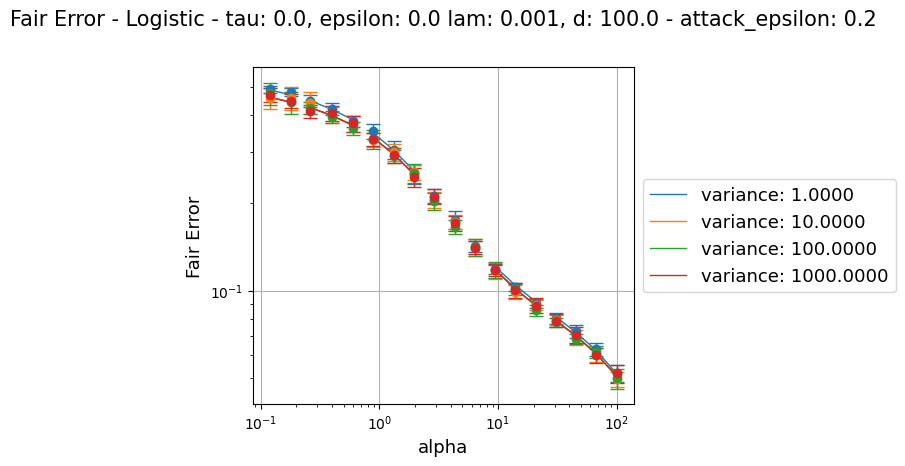

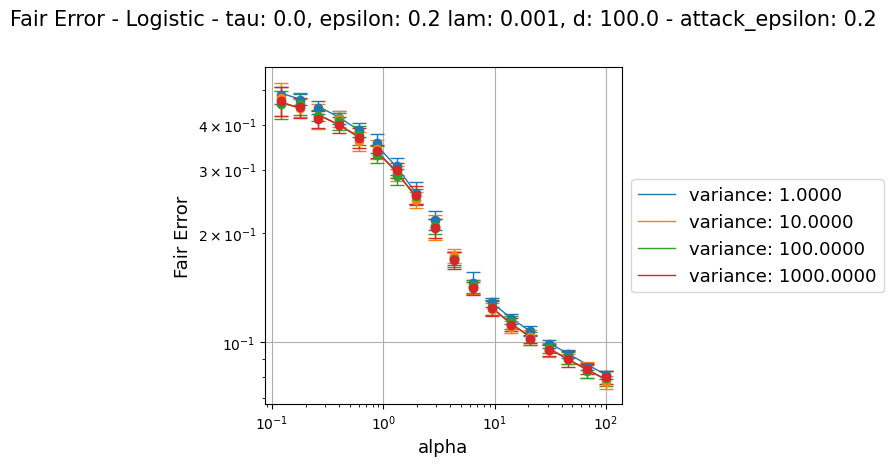

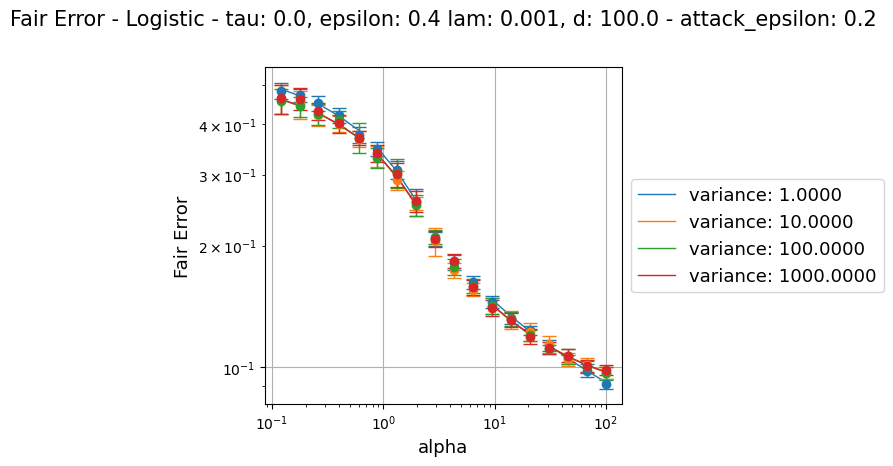

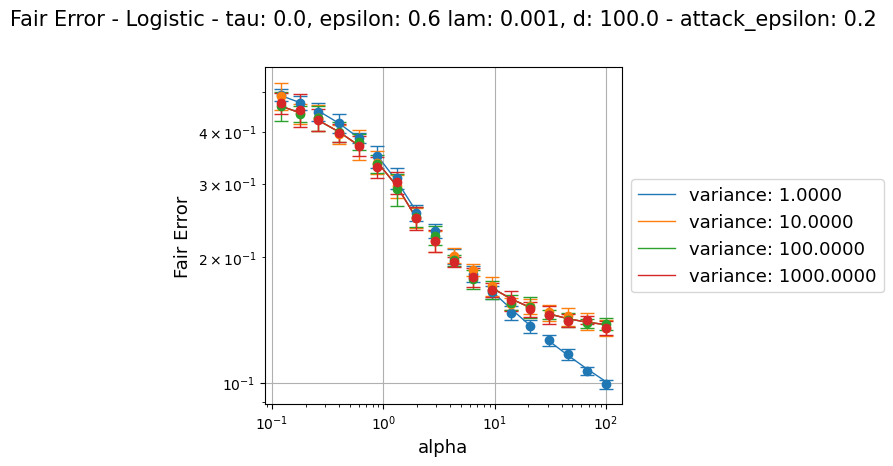

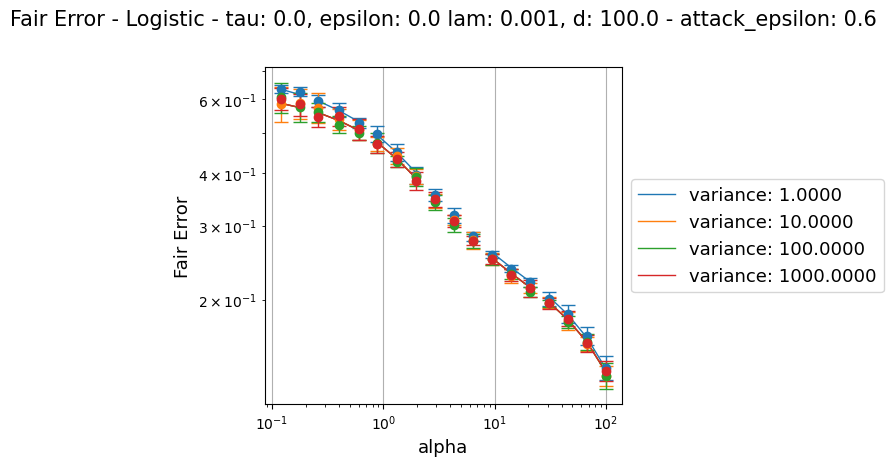

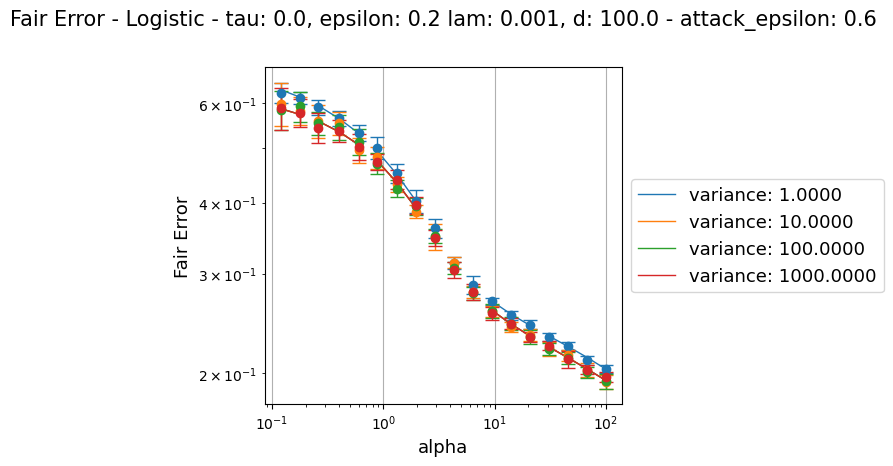

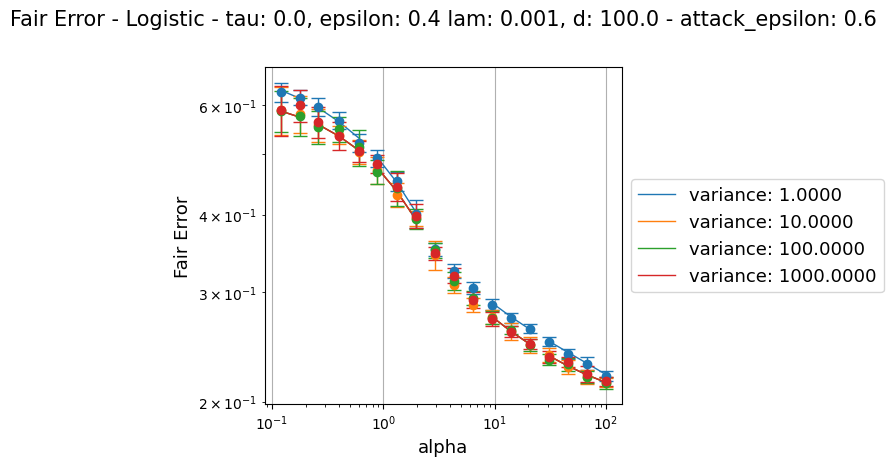

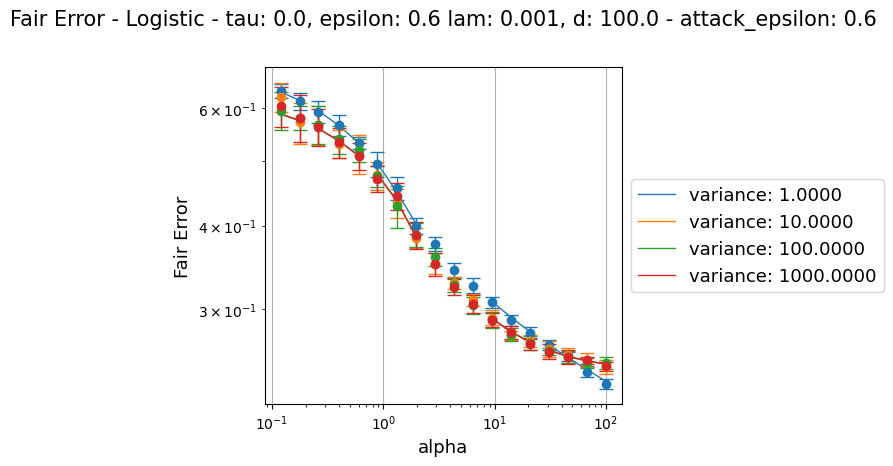

In [124]:
# plot the fair adversarial error
create_plot(df, "Fair Error", "fair_adversarial_error_state_evolution","fair_adversarial_error_erm",plot_attack_epsilon=True)

/ssoft/spack/syrah/v1/opt/spack/linux-rhel8-icelake/gcc-11.3.0/python-3.10.4-mcloxmxhlovfwwkxzyafm35bq545ntqx/lib/python3.10/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/ssoft/spack/syrah/v1/opt/spack/linux-rhel8-icelake/gcc-11.3.0/python-3.10.4-mcloxmxhlovfwwkxzyafm35bq545ntqx/lib/python3.10/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


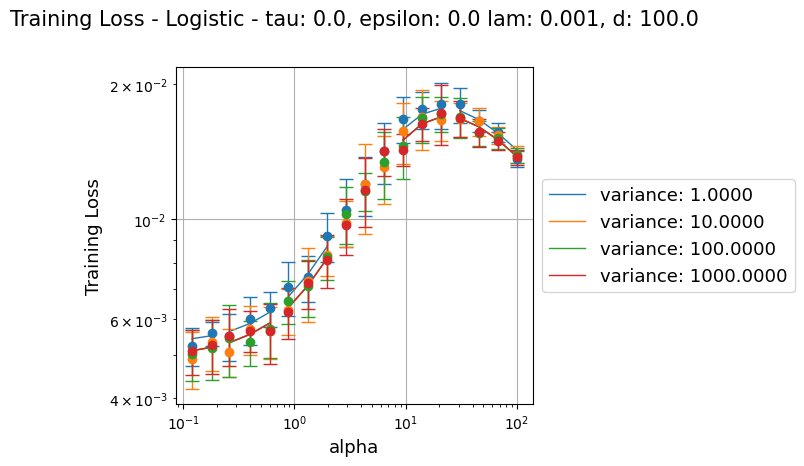

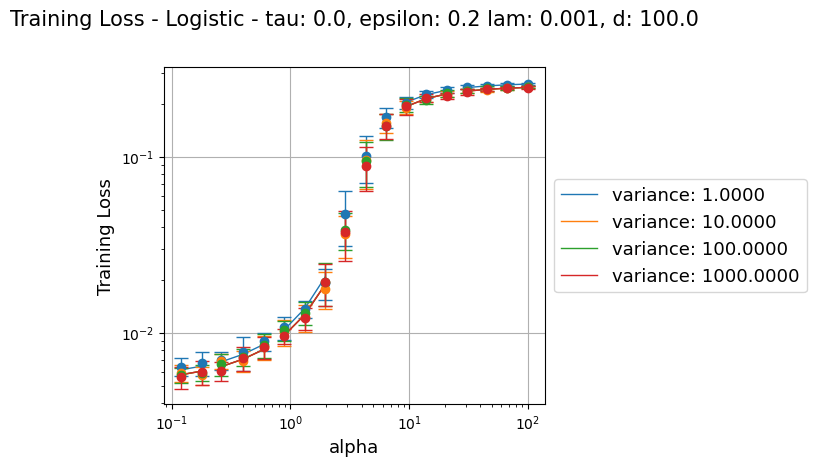

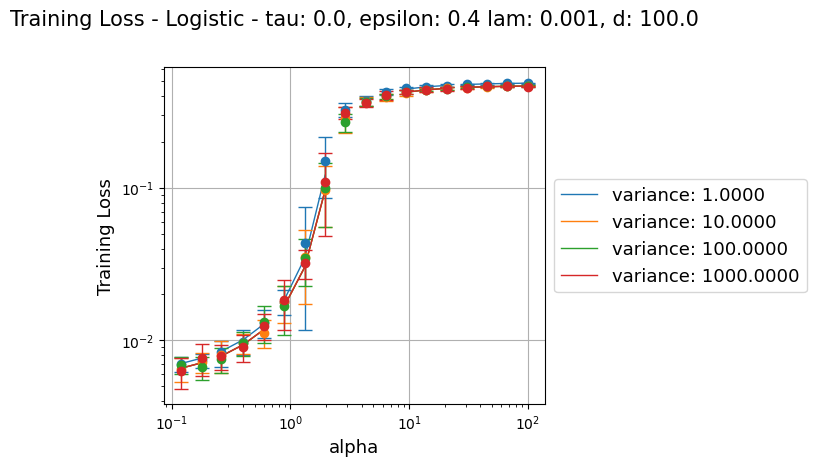

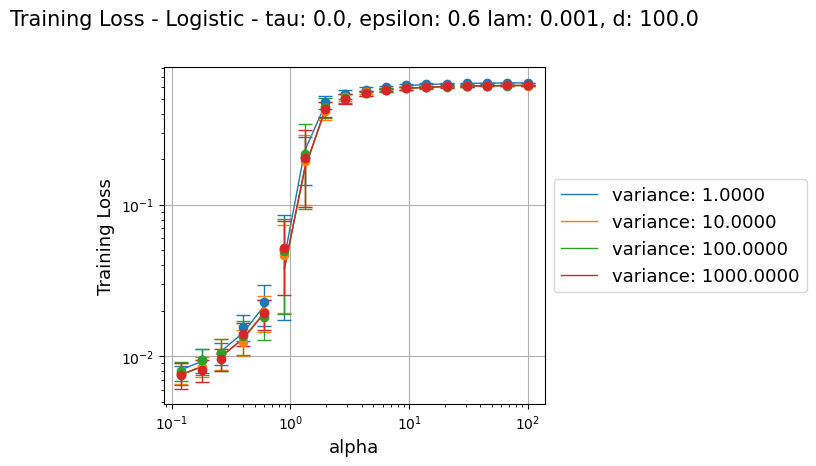

In [125]:
create_plot(df, "Training Loss", "training_loss_state_evolution", "training_loss_erm", log_y=True)

/ssoft/spack/syrah/v1/opt/spack/linux-rhel8-icelake/gcc-11.3.0/python-3.10.4-mcloxmxhlovfwwkxzyafm35bq545ntqx/lib/python3.10/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/ssoft/spack/syrah/v1/opt/spack/linux-rhel8-icelake/gcc-11.3.0/python-3.10.4-mcloxmxhlovfwwkxzyafm35bq545ntqx/lib/python3.10/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


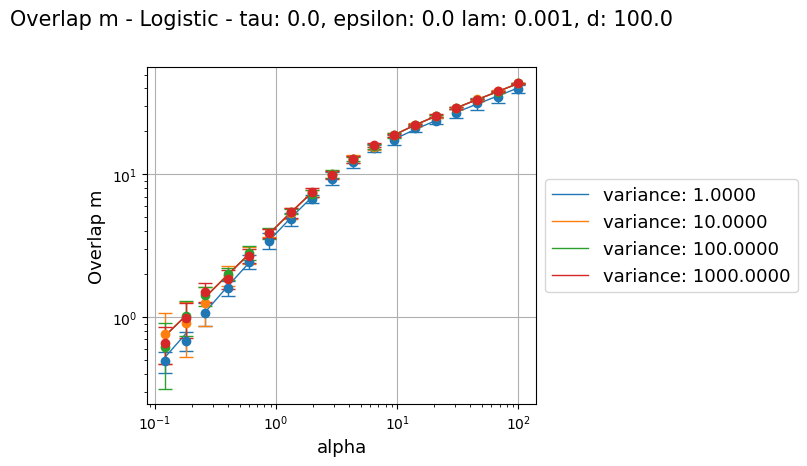

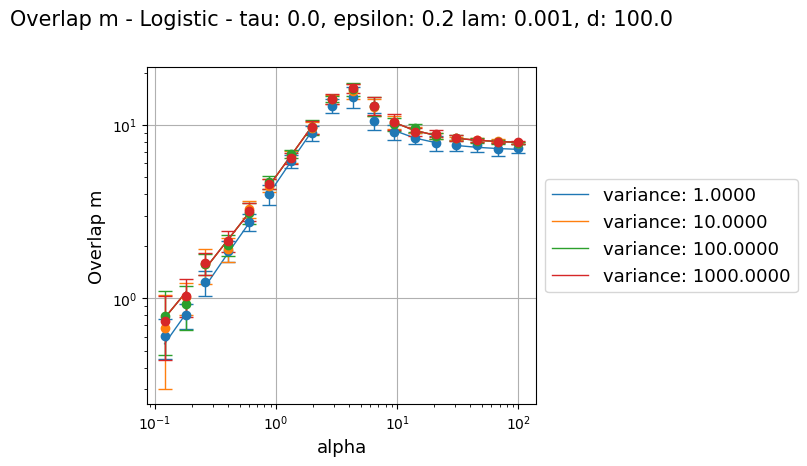

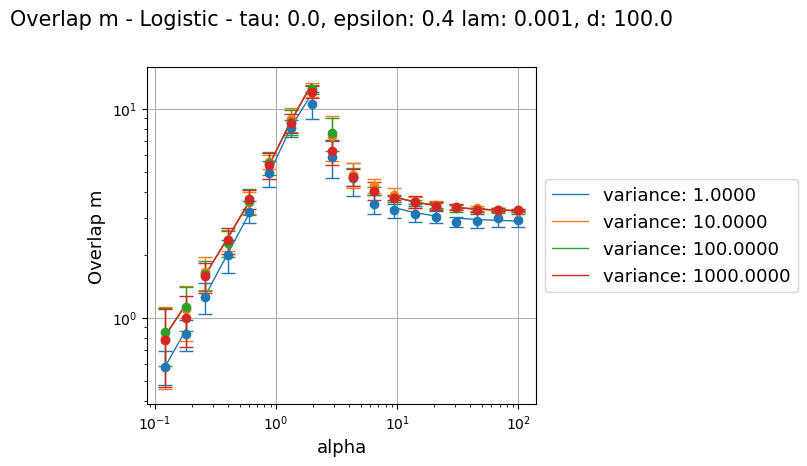

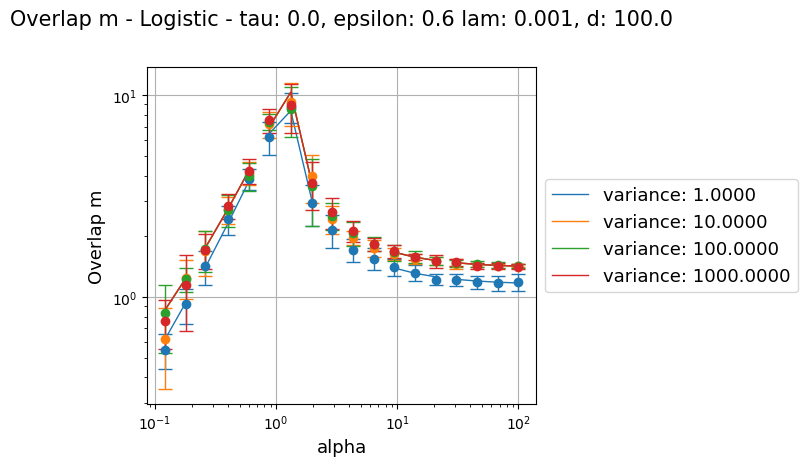

In [126]:
create_plot(df, "Overlap m", "m_state_evolution","m_erm")

/ssoft/spack/syrah/v1/opt/spack/linux-rhel8-icelake/gcc-11.3.0/python-3.10.4-mcloxmxhlovfwwkxzyafm35bq545ntqx/lib/python3.10/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/ssoft/spack/syrah/v1/opt/spack/linux-rhel8-icelake/gcc-11.3.0/python-3.10.4-mcloxmxhlovfwwkxzyafm35bq545ntqx/lib/python3.10/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


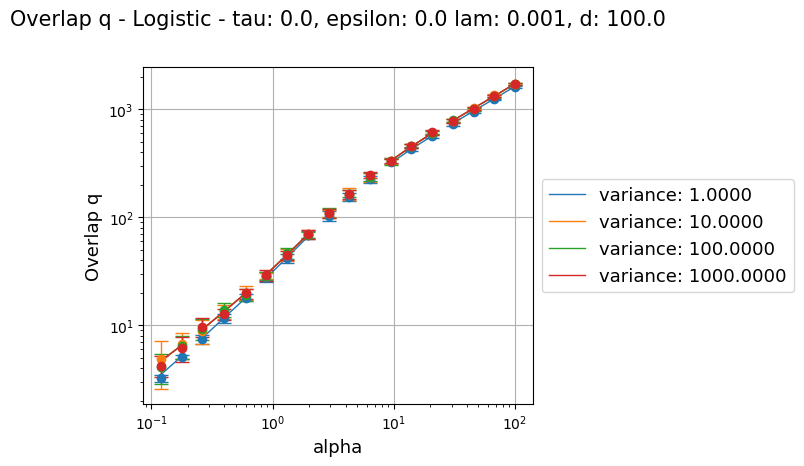

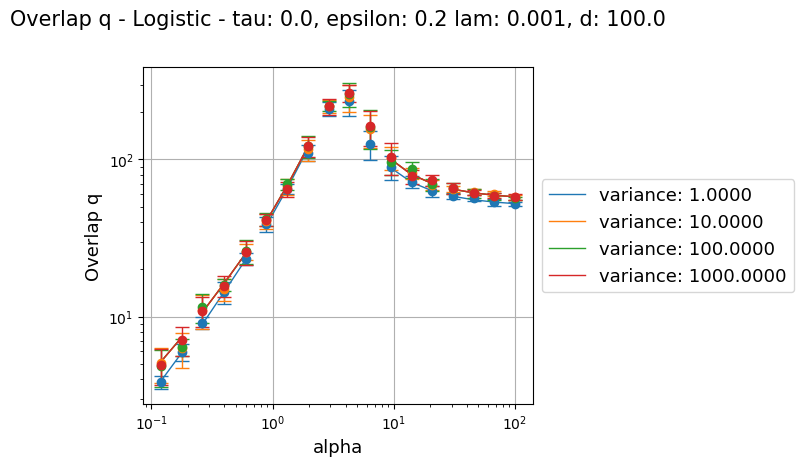

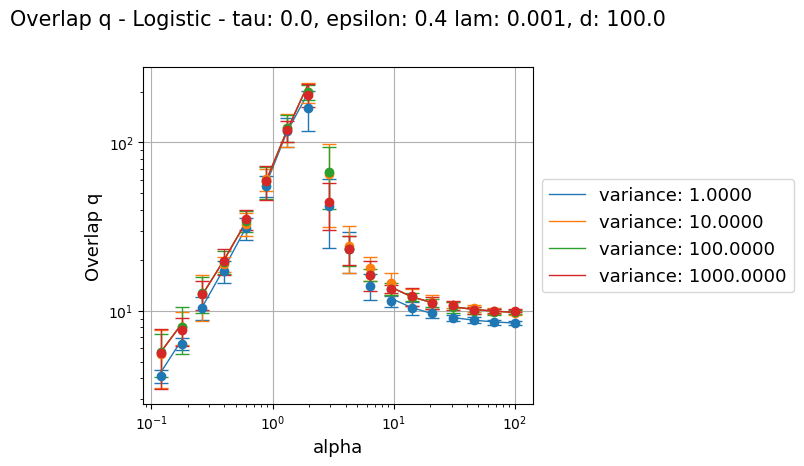

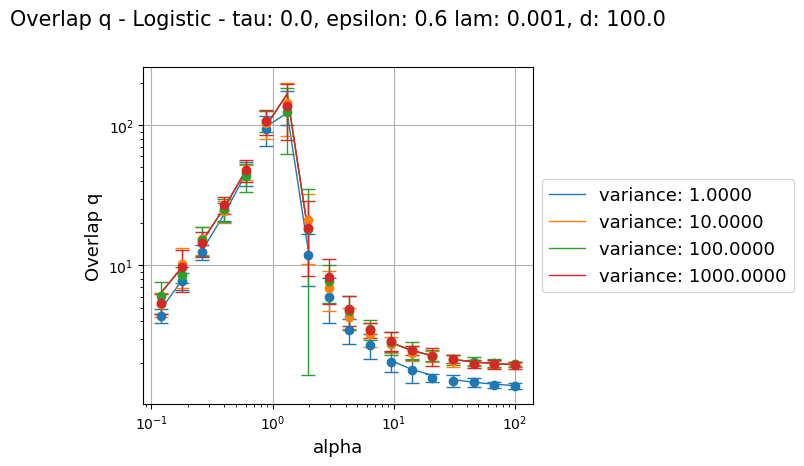

In [127]:
create_plot(df, "Overlap q", "q_state_evolution","Q_erm", log_y=True)

/ssoft/spack/syrah/v1/opt/spack/linux-rhel8-icelake/gcc-11.3.0/python-3.10.4-mcloxmxhlovfwwkxzyafm35bq545ntqx/lib/python3.10/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/ssoft/spack/syrah/v1/opt/spack/linux-rhel8-icelake/gcc-11.3.0/python-3.10.4-mcloxmxhlovfwwkxzyafm35bq545ntqx/lib/python3.10/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


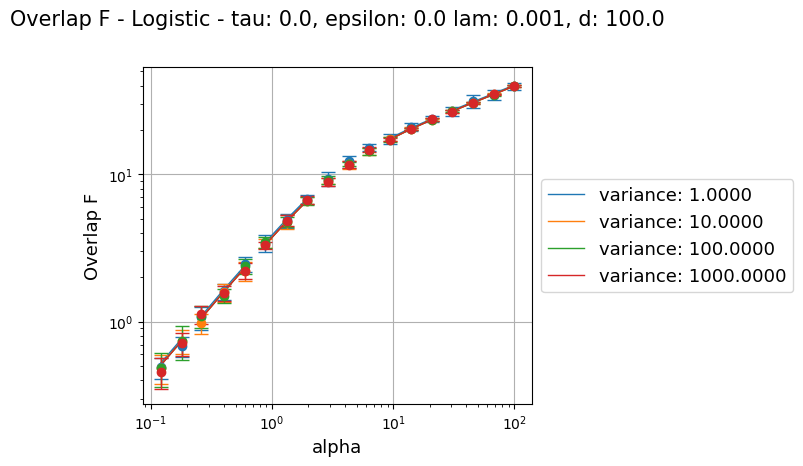

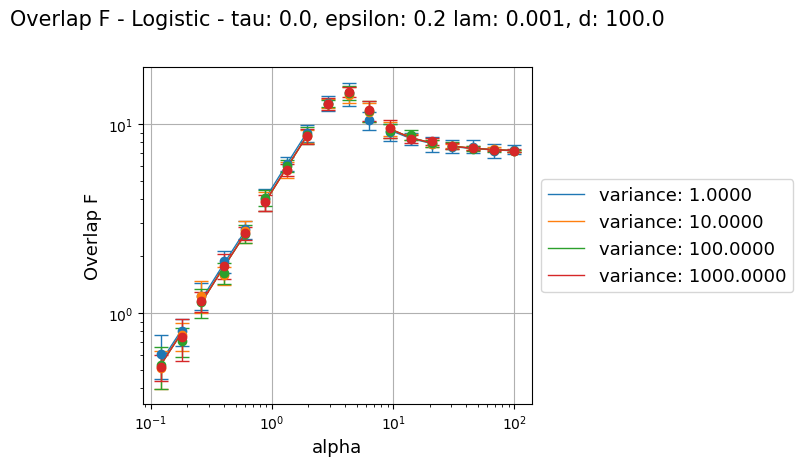

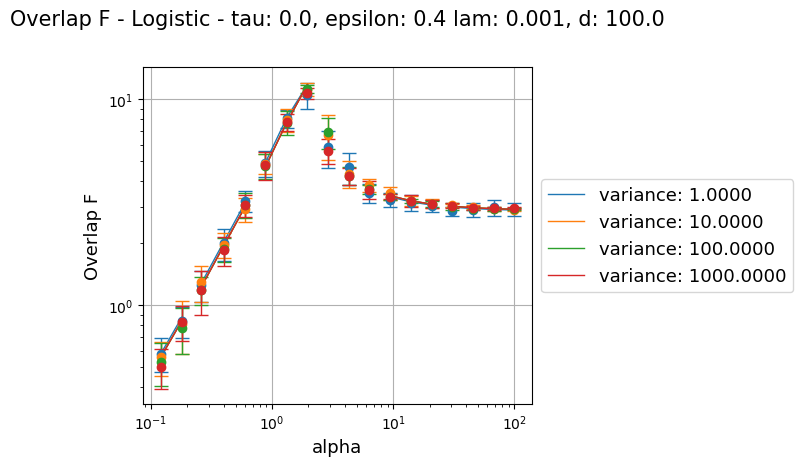

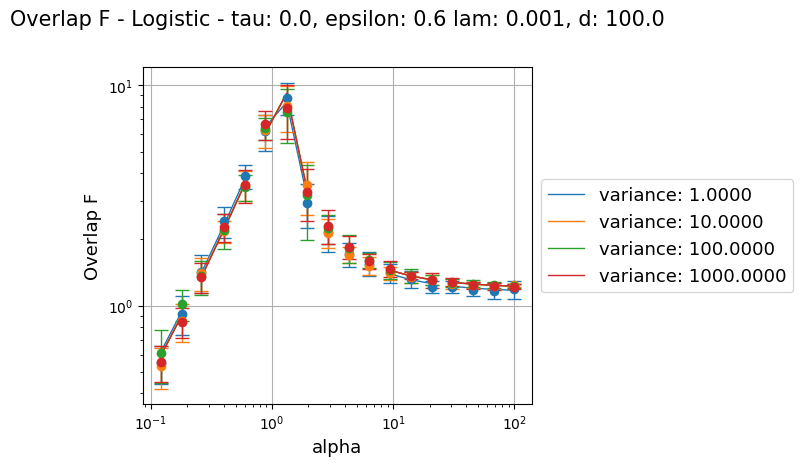

In [128]:
# Plot the F overlap
create_plot(df, "Overlap F", "F_state_evolution","F_erm", log_y=True)

/ssoft/spack/syrah/v1/opt/spack/linux-rhel8-icelake/gcc-11.3.0/python-3.10.4-mcloxmxhlovfwwkxzyafm35bq545ntqx/lib/python3.10/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/ssoft/spack/syrah/v1/opt/spack/linux-rhel8-icelake/gcc-11.3.0/python-3.10.4-mcloxmxhlovfwwkxzyafm35bq545ntqx/lib/python3.10/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


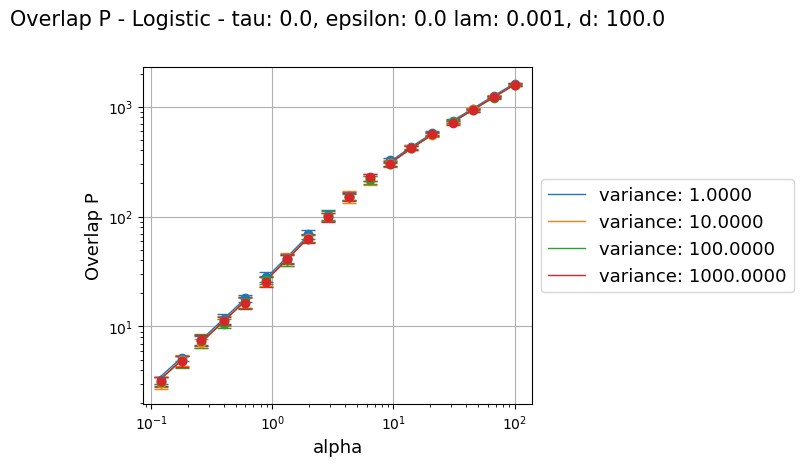

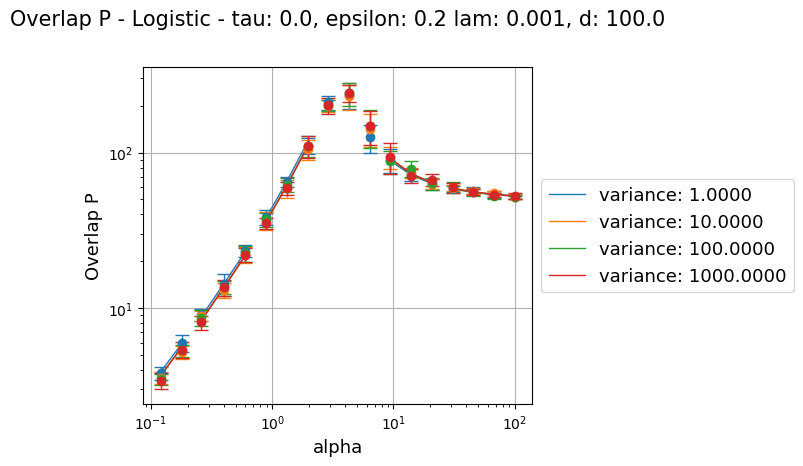

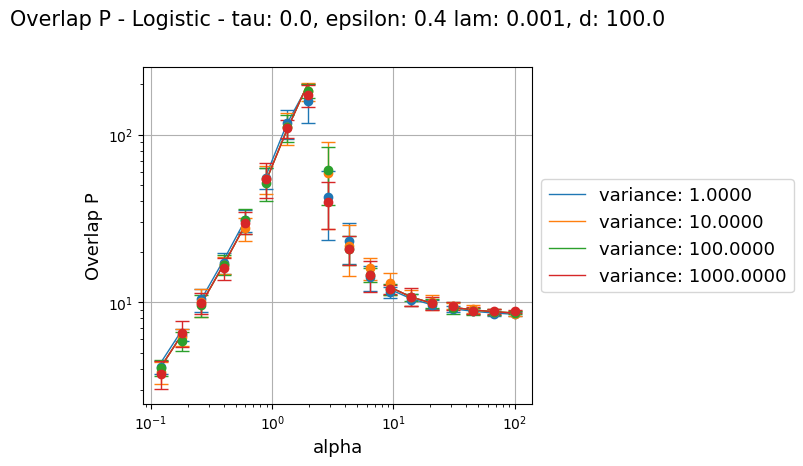

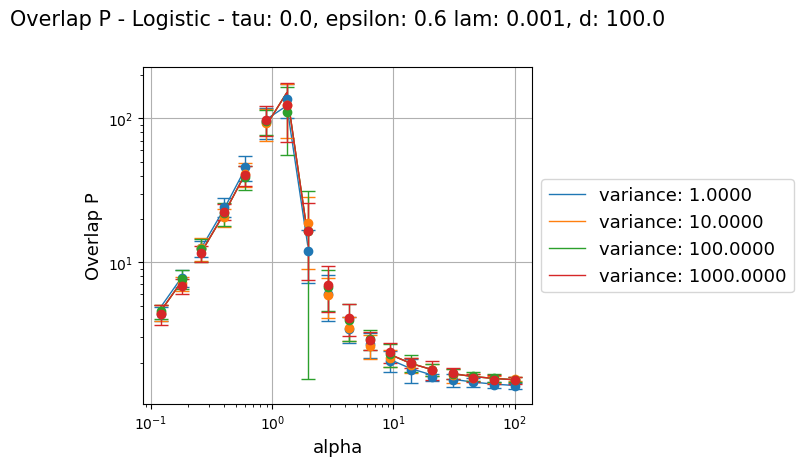

In [129]:
# Plot the P overlap
create_plot(df, "Overlap P", "P_state_evolution","P_erm", log_y=True)

/ssoft/spack/syrah/v1/opt/spack/linux-rhel8-icelake/gcc-11.3.0/python-3.10.4-mcloxmxhlovfwwkxzyafm35bq545ntqx/lib/python3.10/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/ssoft/spack/syrah/v1/opt/spack/linux-rhel8-icelake/gcc-11.3.0/python-3.10.4-mcloxmxhlovfwwkxzyafm35bq545ntqx/lib/python3.10/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


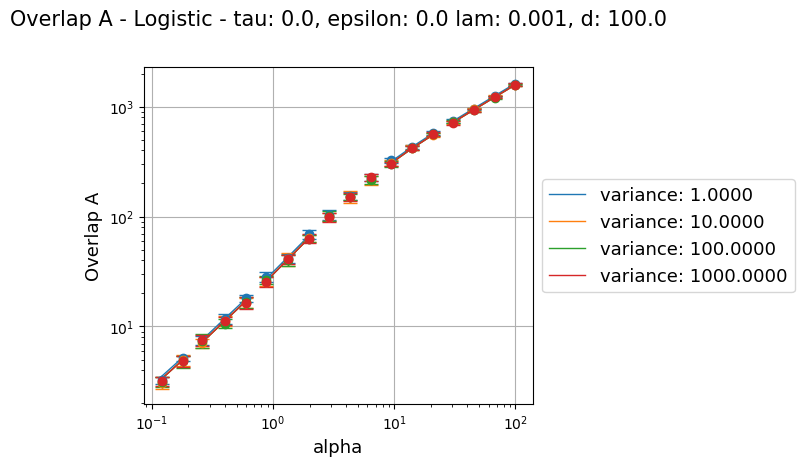

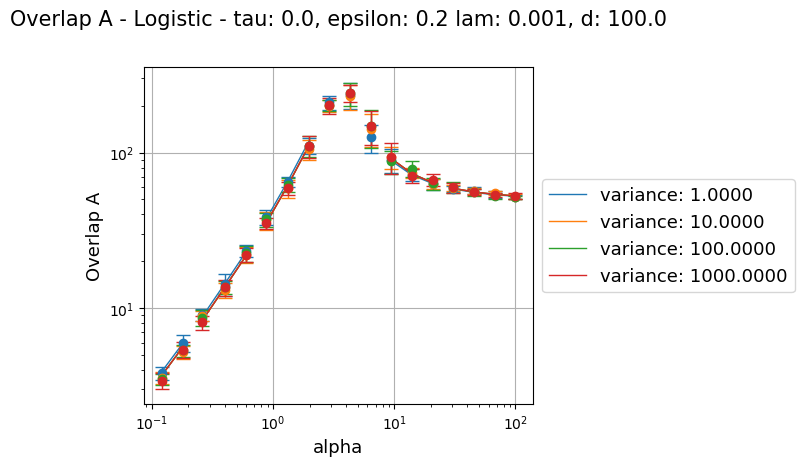

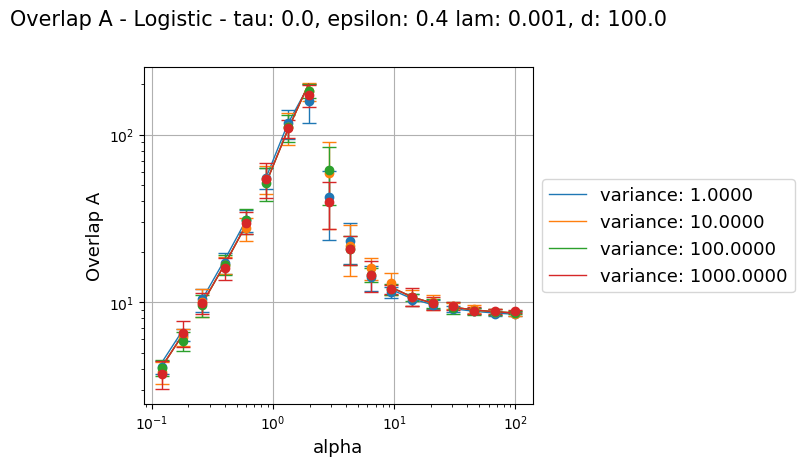

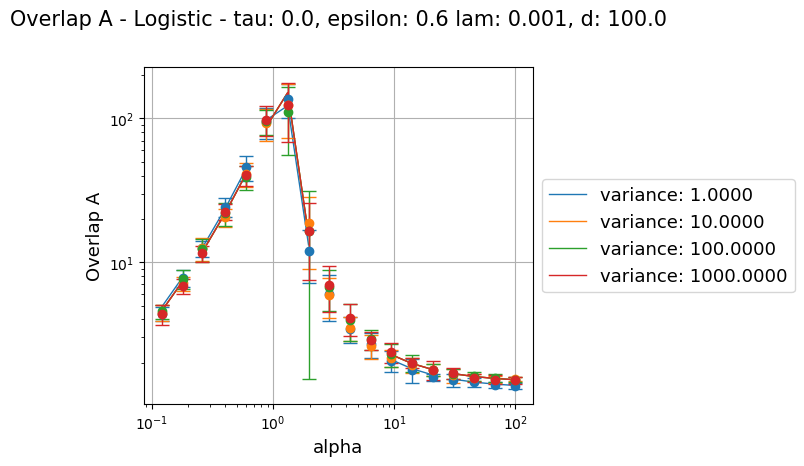

In [130]:
# Plot the A overlap
create_plot(df, "Overlap A", "A_state_evolution","A_erm", log_y=True)

/ssoft/spack/syrah/v1/opt/spack/linux-rhel8-icelake/gcc-11.3.0/python-3.10.4-mcloxmxhlovfwwkxzyafm35bq545ntqx/lib/python3.10/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/ssoft/spack/syrah/v1/opt/spack/linux-rhel8-icelake/gcc-11.3.0/python-3.10.4-mcloxmxhlovfwwkxzyafm35bq545ntqx/lib/python3.10/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


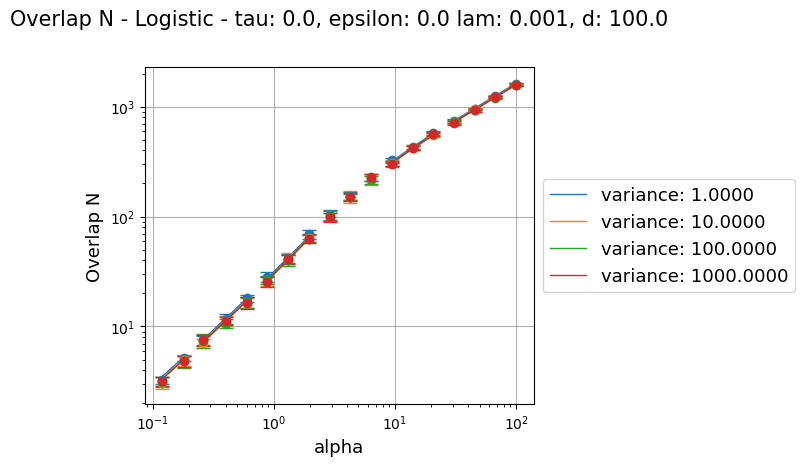

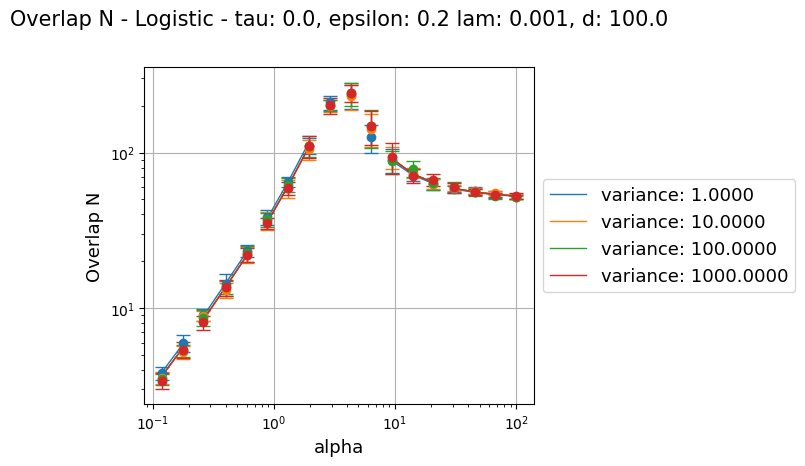

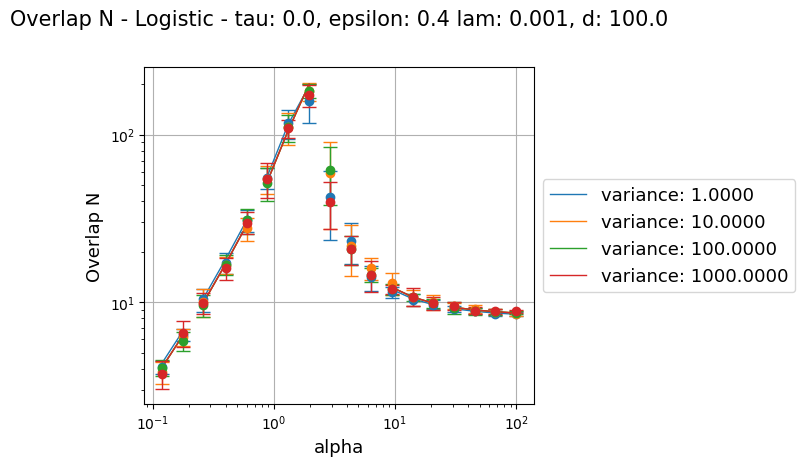

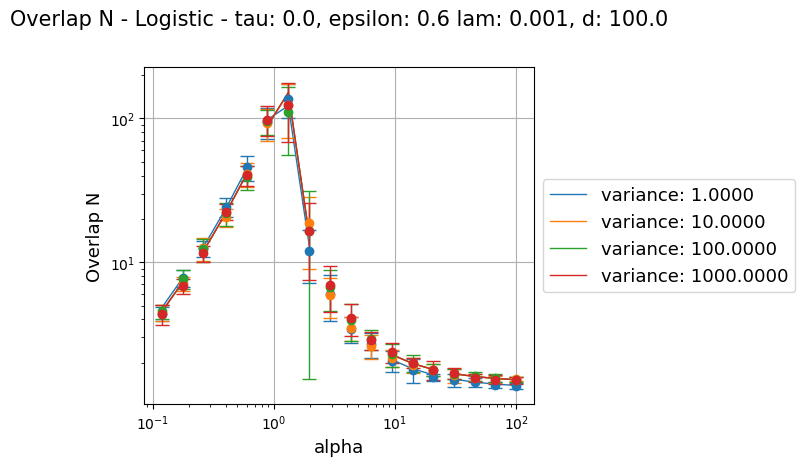

In [131]:
# Plot the N overlap
create_plot(df, "Overlap N", "N_state_evolution","N_erm", log_y=True)

In [132]:
# # subset df to keep only where p = 0.5
# p = 0.6
# dfp = df[df.index.get_level_values("p_calibration") == p]
# # remove epsilon = 1
# # dfp = dfp[dfp.index.get_level_values("epsilon") != 1]

# create_plot(dfp, f"Calibration p: {p}", "calibration_state_evolution","erm_calibration_erm",log_y=False)
# # erm_calibration_erm	analytical_calibration_erm	calibration_state_evolution

/ssoft/spack/syrah/v1/opt/spack/linux-rhel8-icelake/gcc-11.3.0/python-3.10.4-mcloxmxhlovfwwkxzyafm35bq545ntqx/lib/python3.10/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/ssoft/spack/syrah/v1/opt/spack/linux-rhel8-icelake/gcc-11.3.0/python-3.10.4-mcloxmxhlovfwwkxzyafm35bq545ntqx/lib/python3.10/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


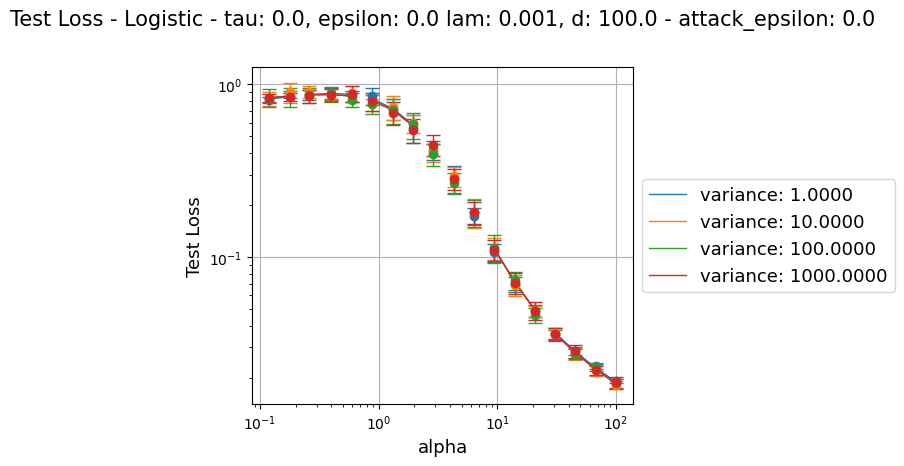

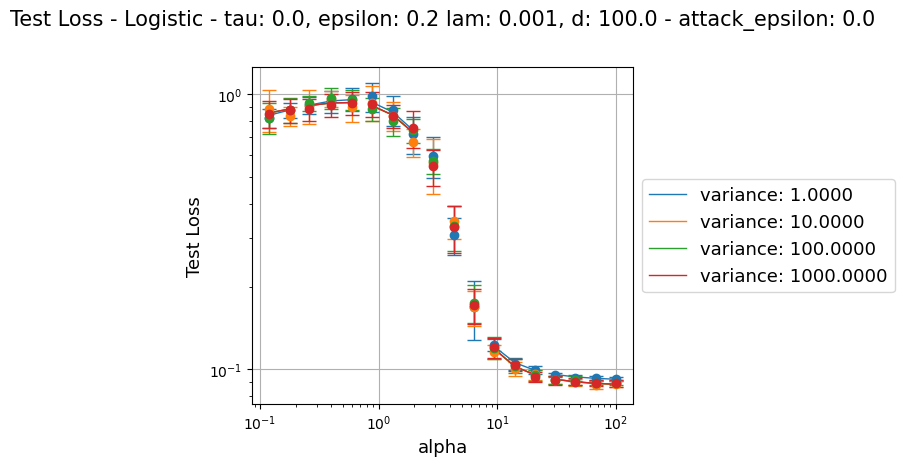

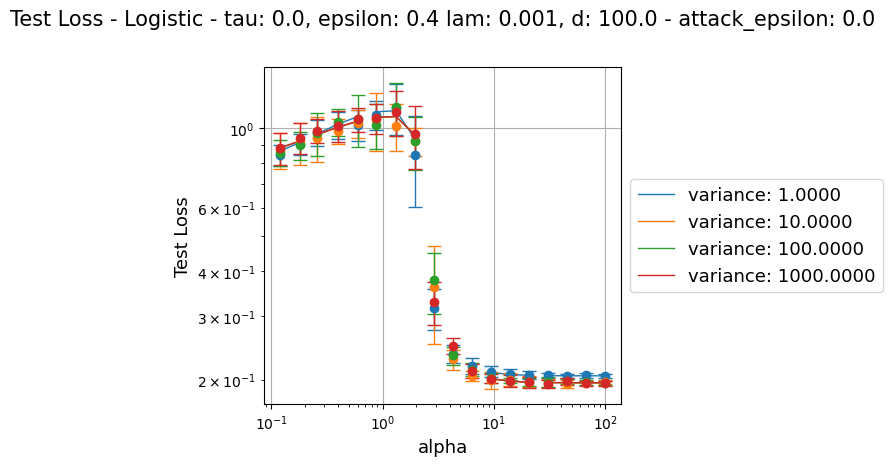

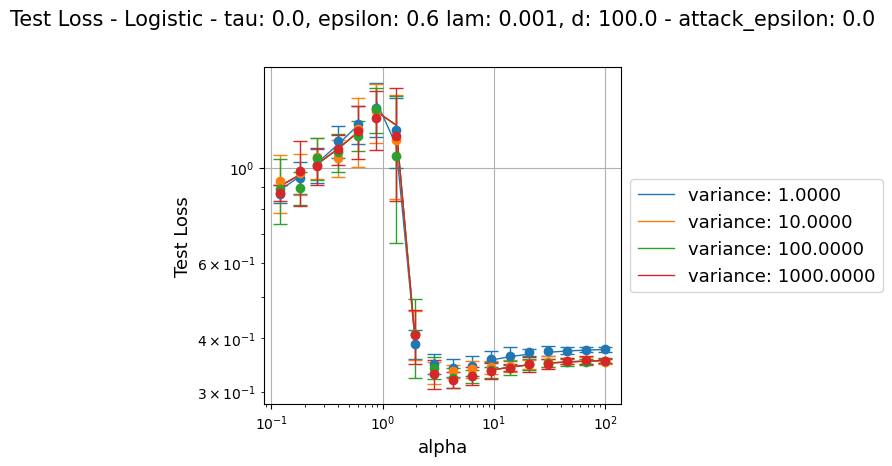

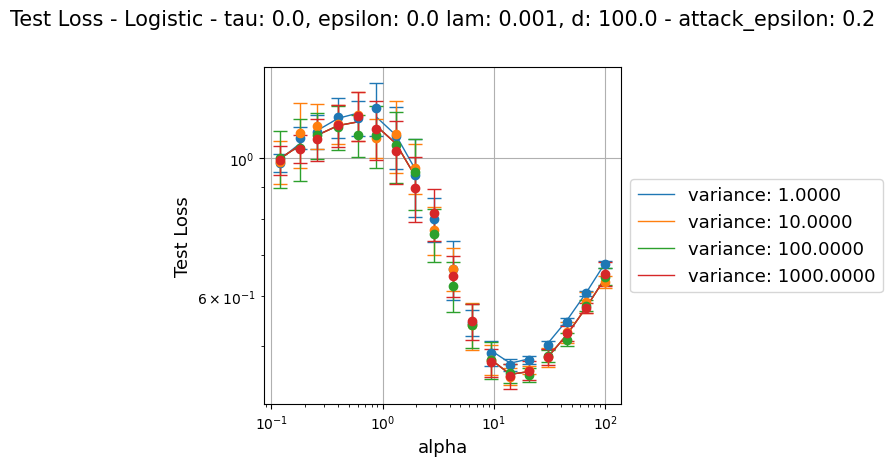

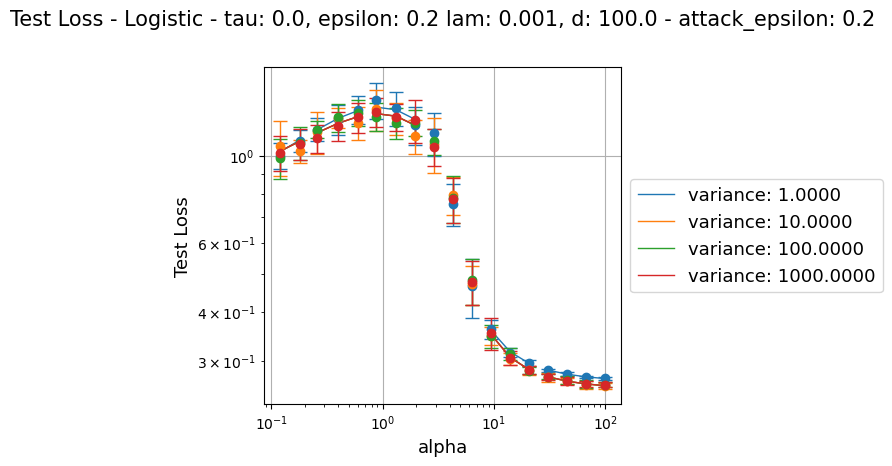

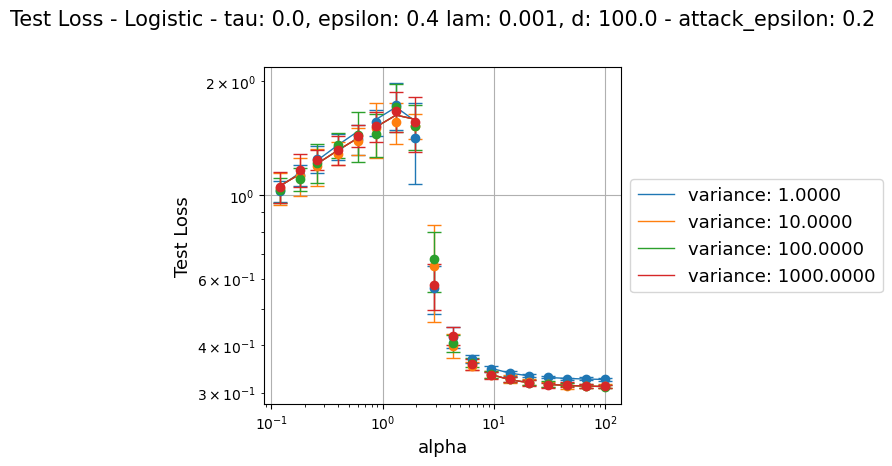

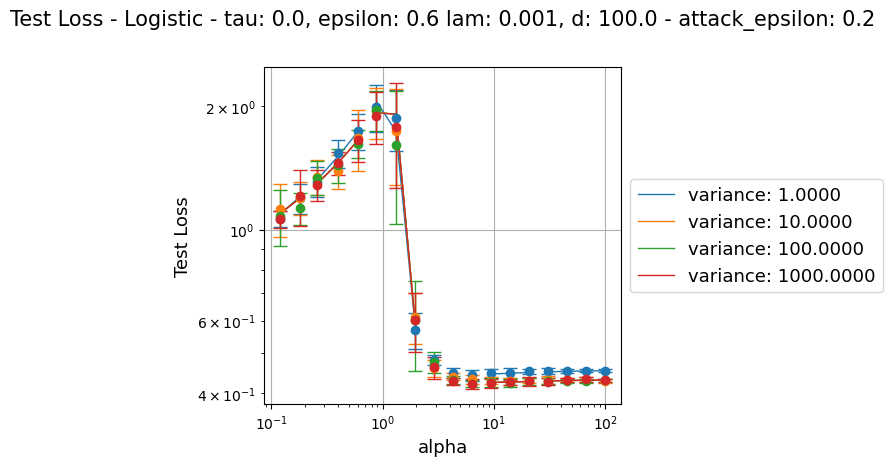

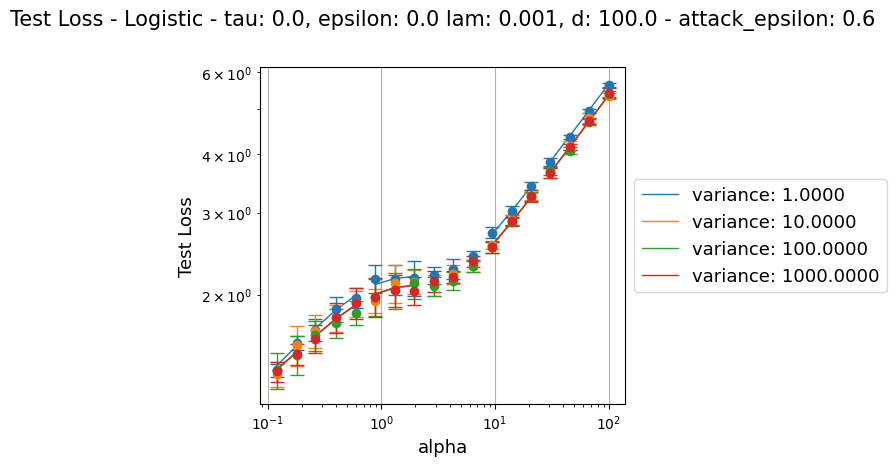

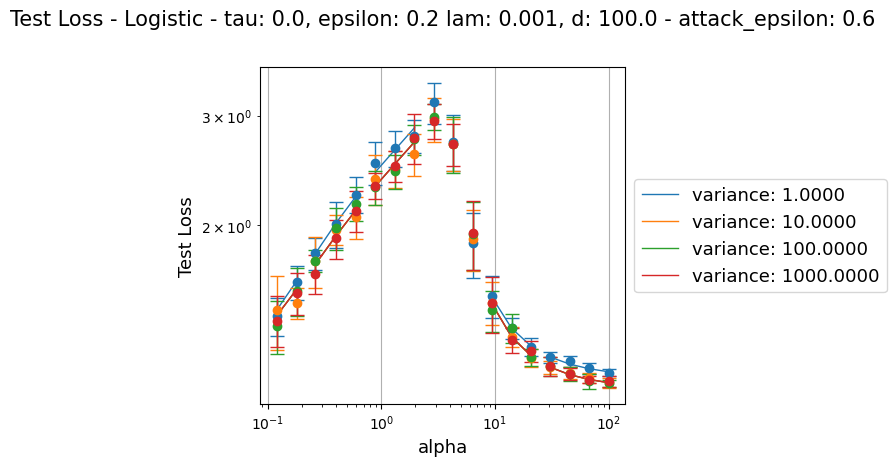

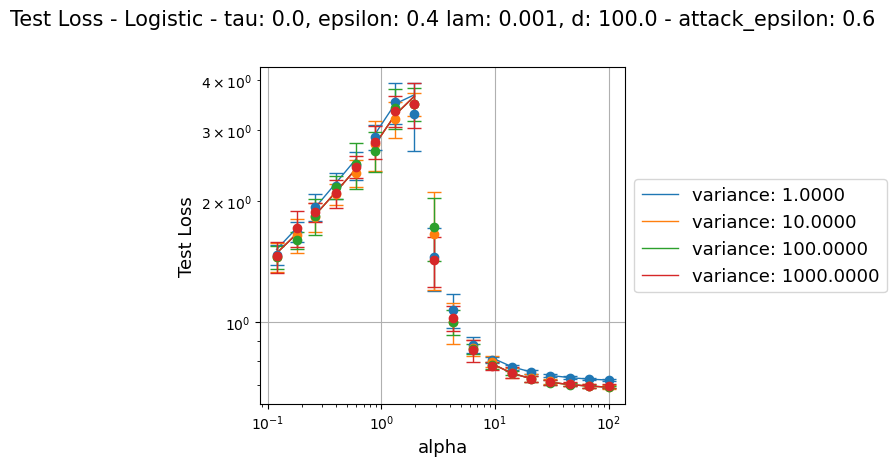

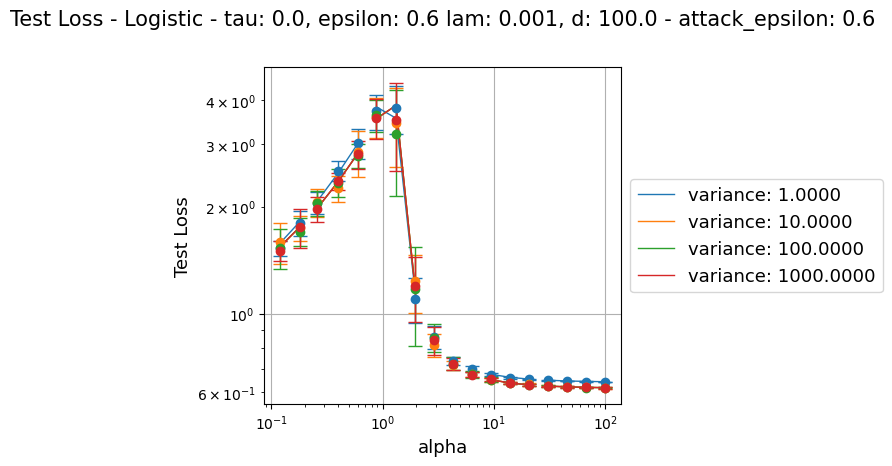

In [133]:
# plot test loss erm
create_plot(df, "Test Loss", "test_loss_state_evolution","test_loss_erm",log_y=True,plot_attack_epsilon=True)

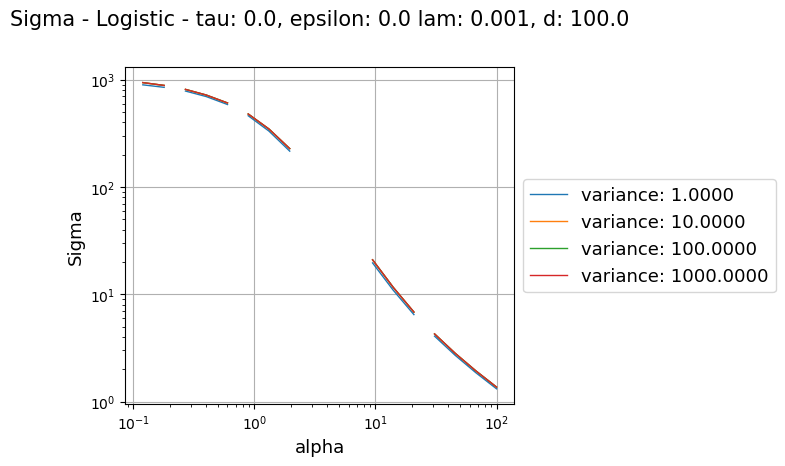

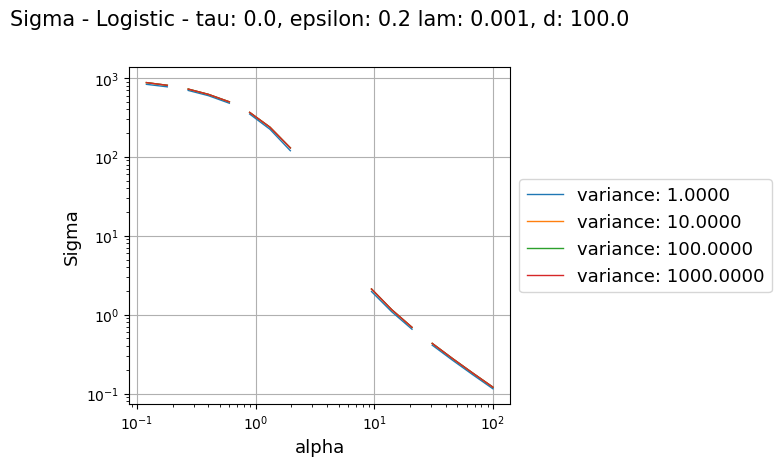

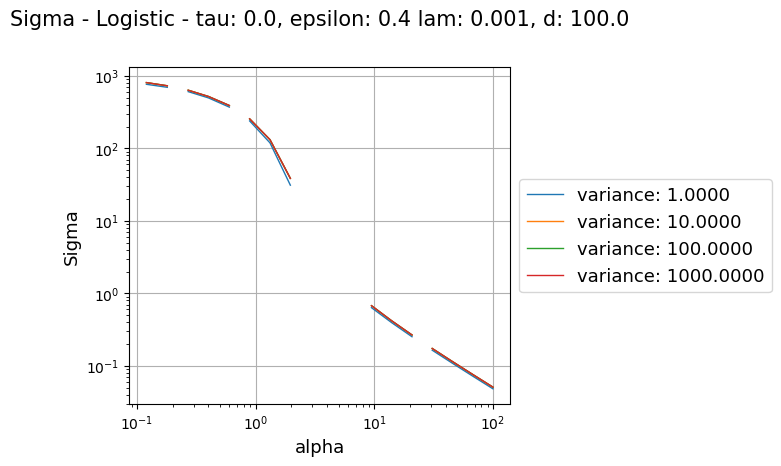

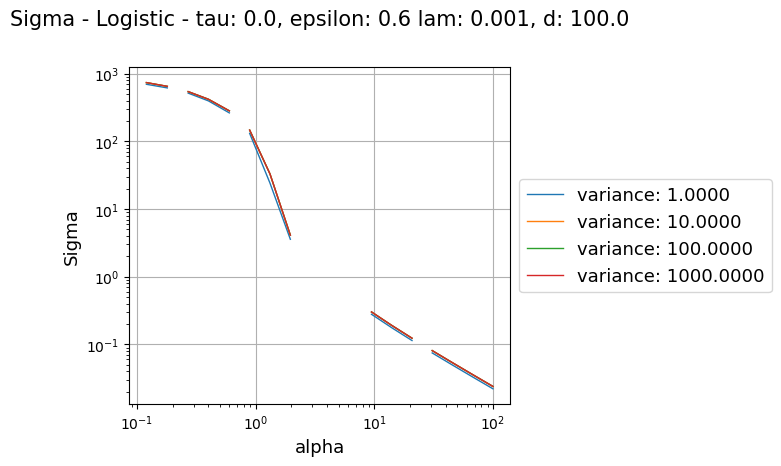

In [134]:
# Plot sigma for the state evolution
create_plot(df, "Sigma", "sigma_state_evolution", None)

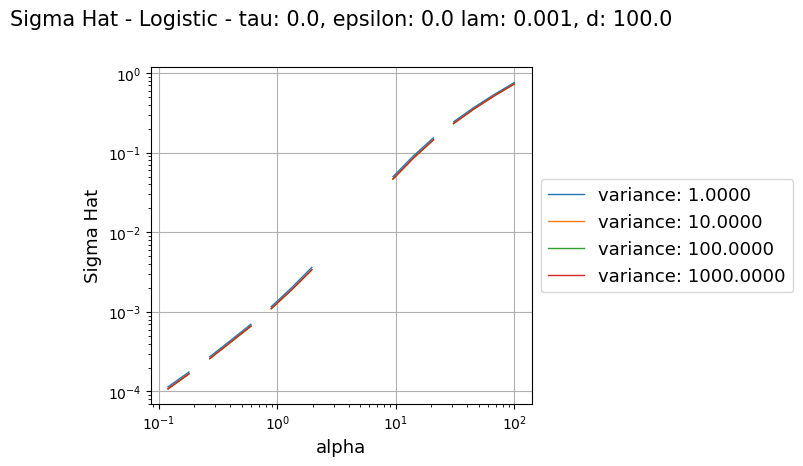

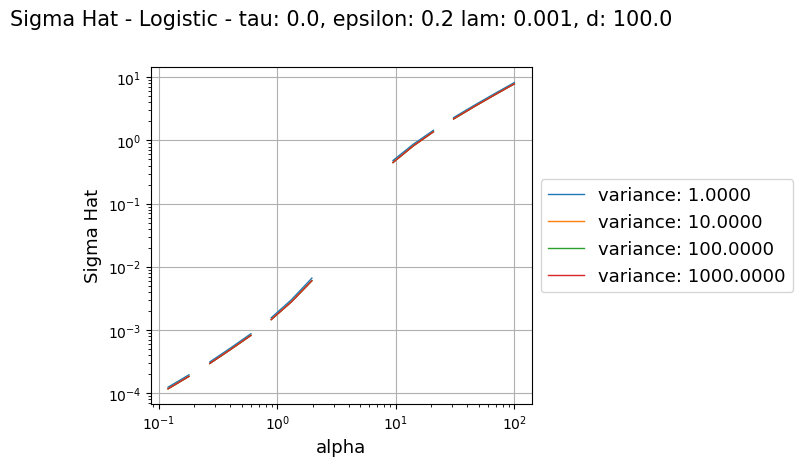

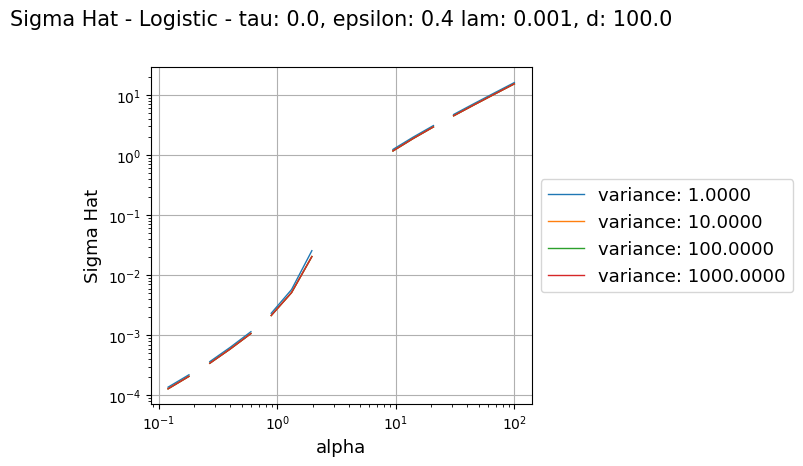

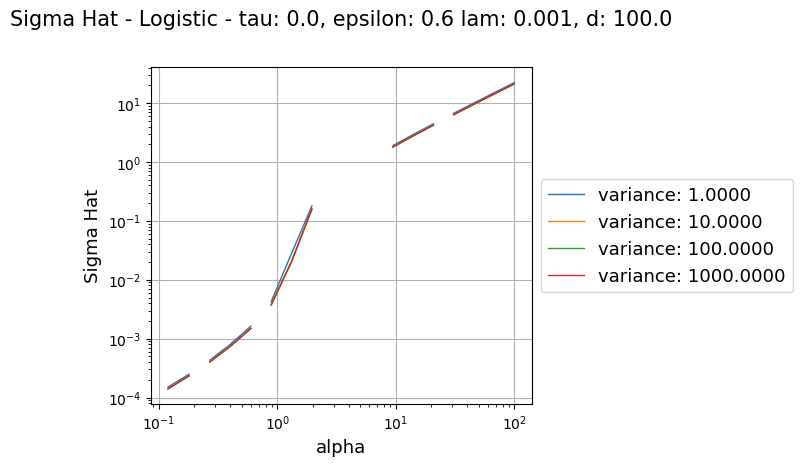

In [135]:
# Plot sigma_hat for the state evolution
create_plot(df, "Sigma Hat", "sigma_hat_state_evolution", None)

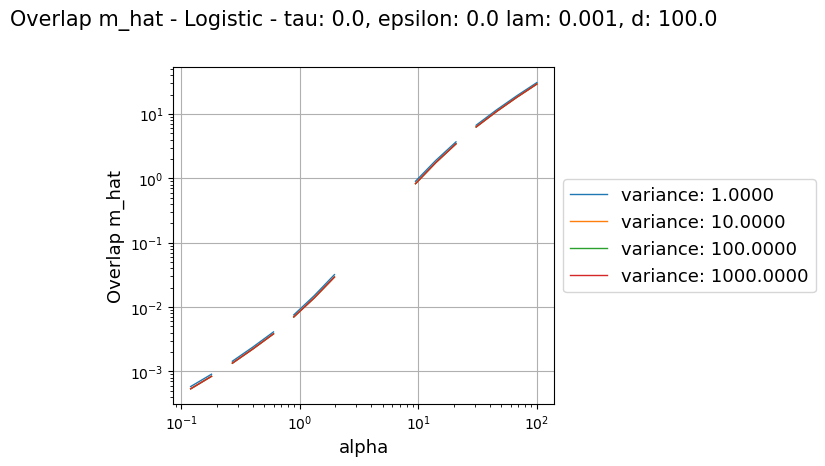

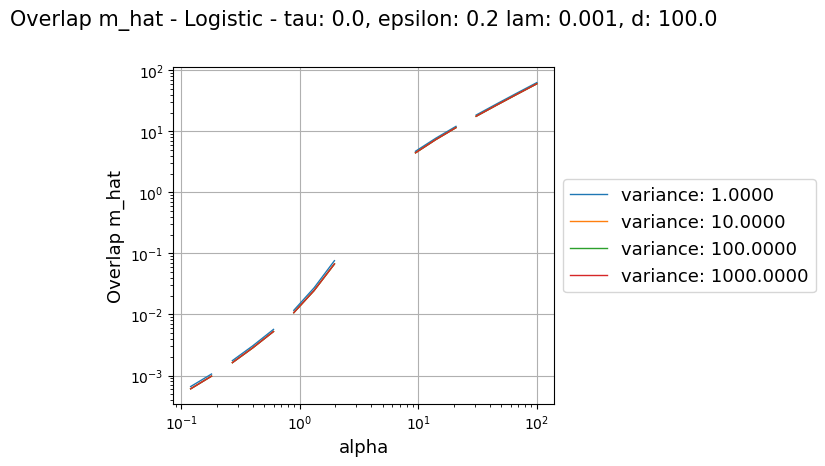

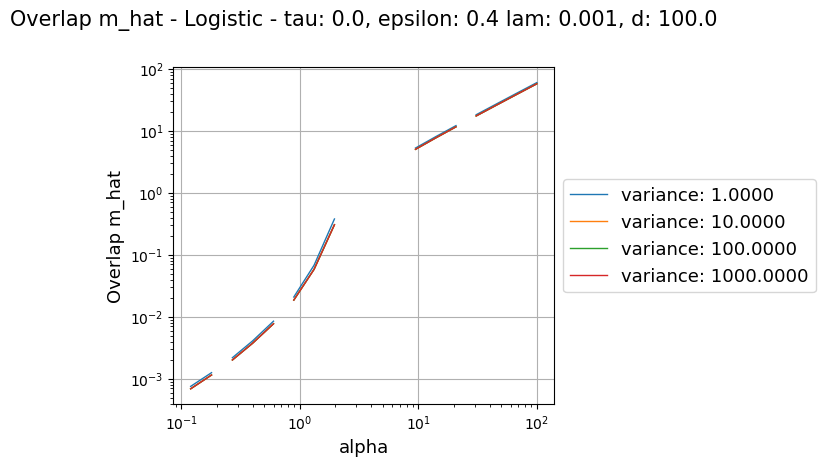

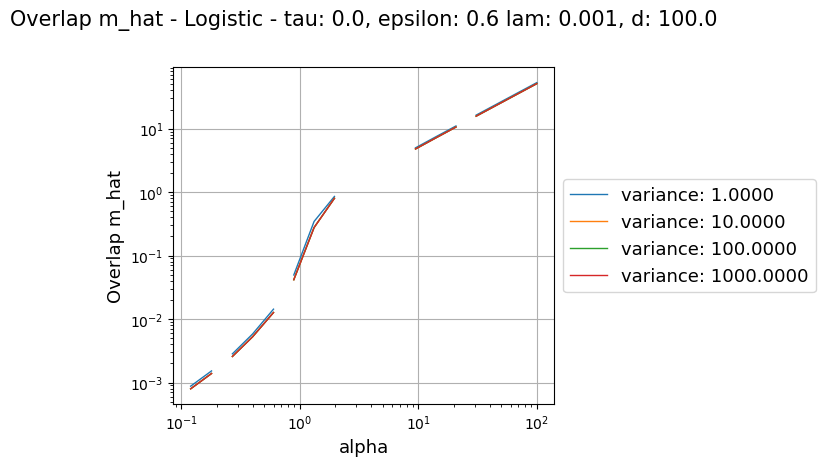

In [136]:
# Plot m_hat for the state evolution
create_plot(df, "Overlap m_hat", "m_hat_state_evolution", None)

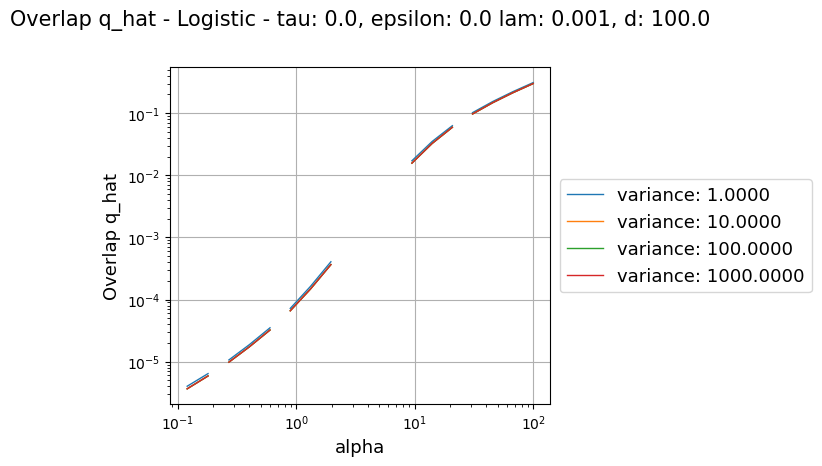

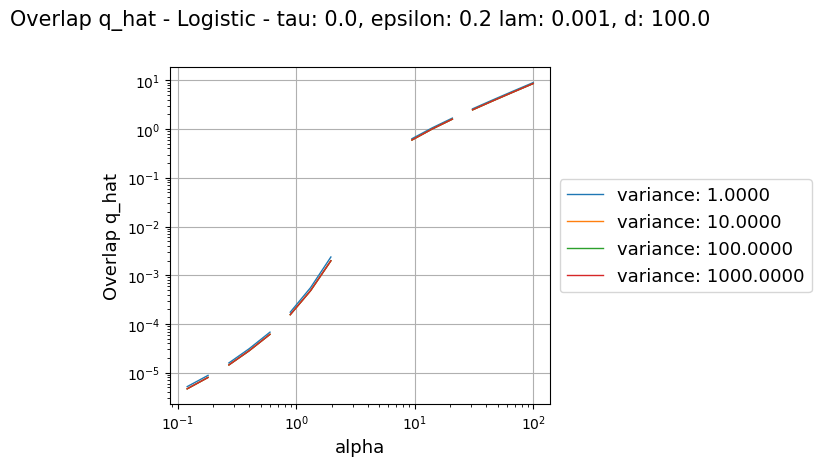

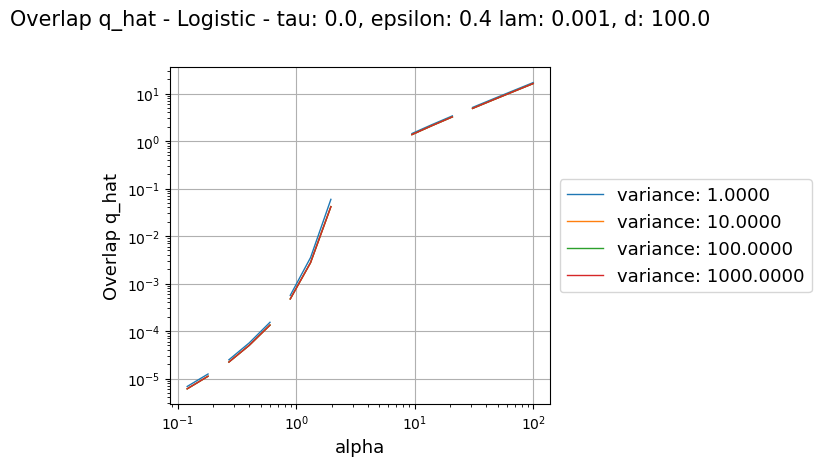

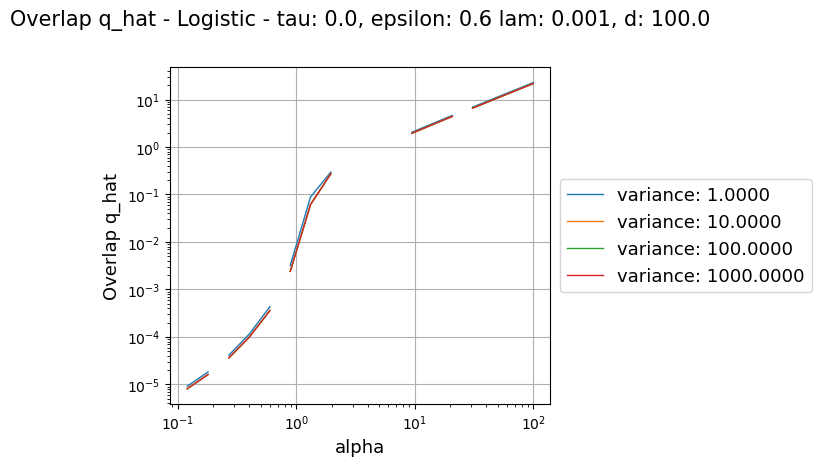

In [137]:
# Plot q_hat for the state_evolution
create_plot(df, "Overlap q_hat", "q_hat_state_evolution", None)

/ssoft/spack/syrah/v1/opt/spack/linux-rhel8-icelake/gcc-11.3.0/python-3.10.4-mcloxmxhlovfwwkxzyafm35bq545ntqx/lib/python3.10/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/ssoft/spack/syrah/v1/opt/spack/linux-rhel8-icelake/gcc-11.3.0/python-3.10.4-mcloxmxhlovfwwkxzyafm35bq545ntqx/lib/python3.10/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


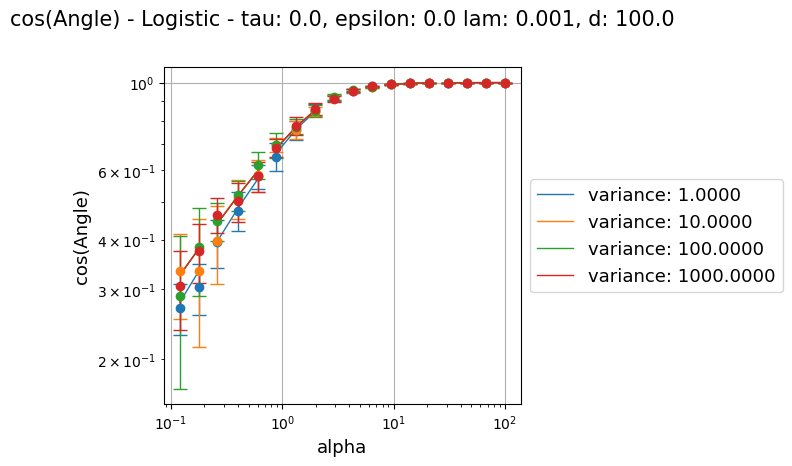

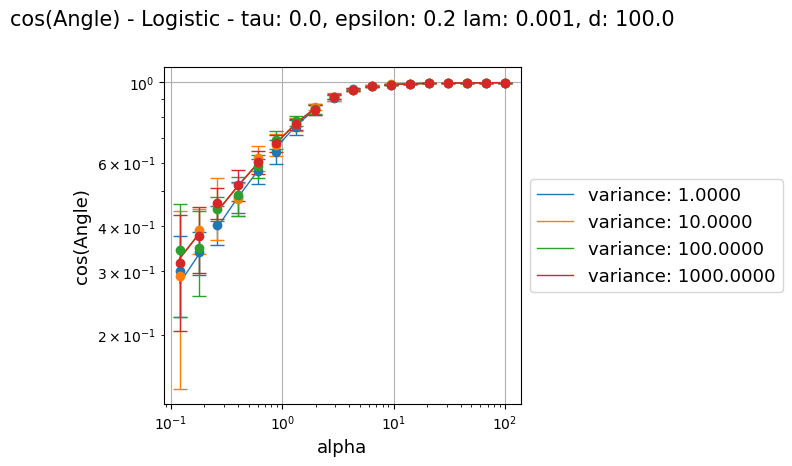

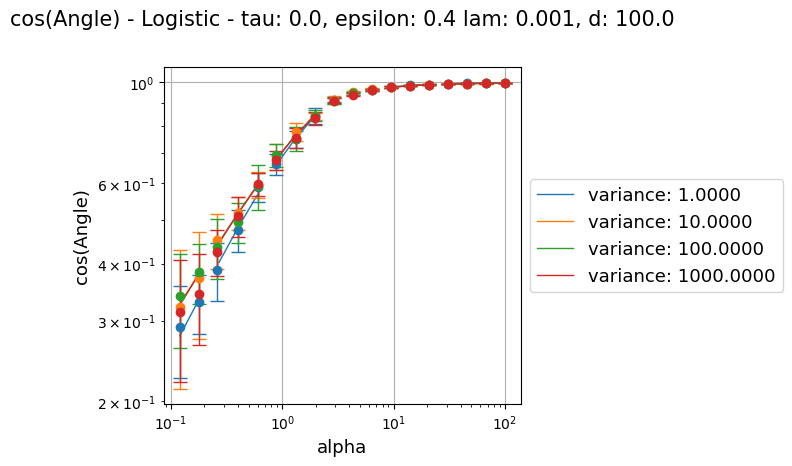

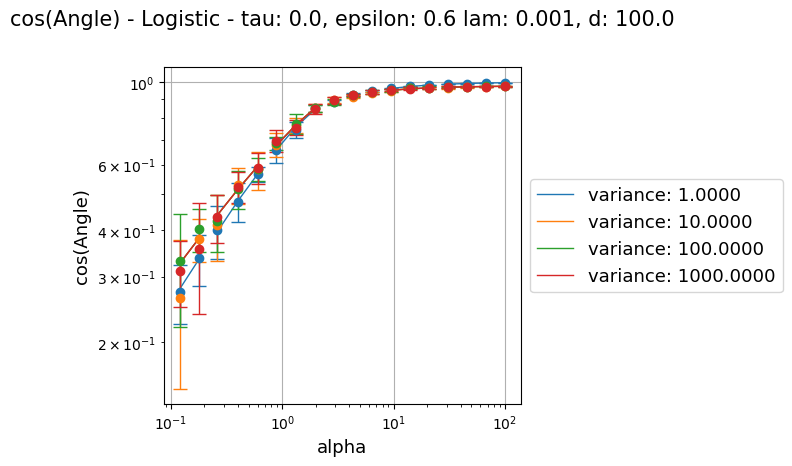

In [138]:
create_plot(df, "cos(Angle)", "angle_state_evolution","angle_erm")